# **Lab 3: Quantization**

# Setup

In [7]:
import copy
import math
import random
from collections import OrderedDict, defaultdict

from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
from tqdm.auto import tqdm
from torchvision.models.quantization import mobilenet_v2


import torch
from torch import nn

In [8]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

In [9]:
model = torch.load('mobilenetv2_for_quant.pth', map_location="cpu")

Test Functions **(DO NOT MODIFY!!)**

In [10]:
def test_linear_quantize(
    test_tensor=torch.tensor([
        [ 0.0523,  0.6364, -0.0968, -0.0020,  0.1940],
        [ 0.7500,  0.5507,  0.6188, -0.1734,  0.4677],
        [-0.0669,  0.3836,  0.4297,  0.6267, -0.0695],
        [ 0.1536, -0.0038,  0.6075,  0.6817,  0.0601],
        [ 0.6446, -0.2500,  0.5376, -0.2226,  0.2333]]),
    quantized_test_tensor=torch.tensor([
        [-1,  1, -1, -1,  0],
        [ 1,  1,  1, -2,  0],
        [-1,  0,  0,  1, -1],
        [-1, -1,  1,  1, -1],
        [ 1, -2,  1, -2,  0]], dtype=torch.int8),
    real_min=-0.25, real_max=0.75, bitwidth=2, scale=1/3, zero_point=-1):
    def plot_matrix(tensor, ax, title, vmin=0, vmax=1, cmap=ListedColormap(['white'])):
        ax.imshow(tensor.cpu().numpy(), vmin=vmin, vmax=vmax, cmap=cmap)
        ax.set_title(title)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        for i in range(tensor.shape[0]):
            for j in range(tensor.shape[1]):
                datum = tensor[i, j].item()
                if isinstance(datum, float):
                    text = ax.text(j, i, f'{datum:.2f}',
                                    ha="center", va="center", color="k")
                else:
                    text = ax.text(j, i, f'{datum}',
                                    ha="center", va="center", color="k")
    quantized_min, quantized_max = get_quantized_range(bitwidth)
    fig, axes = plt.subplots(1,3, figsize=(10, 32))
    plot_matrix(test_tensor, axes[0], 'original tensor', vmin=real_min, vmax=real_max)
    _quantized_test_tensor = linear_quantize(
        test_tensor, bitwidth=bitwidth, scale=scale, zero_point=zero_point)
    _reconstructed_test_tensor = scale * (_quantized_test_tensor.float() - zero_point)
    print('* Test linear_quantize()')
    print(f'    target bitwidth: {bitwidth} bits')
    print(f'        scale: {scale}')
    print(f'        zero point: {zero_point}')
    assert _quantized_test_tensor.equal(quantized_test_tensor)
    print('* Test passed.')
    plot_matrix(_quantized_test_tensor, axes[1], f'2-bit linear quantized tensor',
                vmin=quantized_min, vmax=quantized_max, cmap='tab20c')
    plot_matrix(_reconstructed_test_tensor, axes[2], f'reconstructed tensor',
                vmin=real_min, vmax=real_max, cmap='tab20c')
    fig.tight_layout()
    plt.show()


In [11]:
def test_quantized_fc(
    input=torch.tensor([
        [0.6118, 0.7288, 0.8511, 0.2849, 0.8427, 0.7435, 0.4014, 0.2794],
        [0.3676, 0.2426, 0.1612, 0.7684, 0.6038, 0.0400, 0.2240, 0.4237],
        [0.6565, 0.6878, 0.4670, 0.3470, 0.2281, 0.8074, 0.0178, 0.3999],
        [0.1863, 0.3567, 0.6104, 0.0497, 0.0577, 0.2990, 0.6687, 0.8626]]),
    weight=torch.tensor([
        [ 1.2626e-01, -1.4752e-01,  8.1910e-02,  2.4982e-01, -1.0495e-01,
         -1.9227e-01, -1.8550e-01, -1.5700e-01],
        [ 2.7624e-01, -4.3835e-01,  5.1010e-02, -1.2020e-01, -2.0344e-01,
          1.0202e-01, -2.0799e-01,  2.4112e-01],
        [-3.8216e-01, -2.8047e-01,  8.5238e-02, -4.2504e-01, -2.0952e-01,
          3.2018e-01, -3.3619e-01,  2.0219e-01],
        [ 8.9233e-02, -1.0124e-01,  1.1467e-01,  2.0091e-01,  1.1438e-01,
         -4.2427e-01,  1.0178e-01, -3.0941e-04],
        [-1.8837e-02, -2.1256e-01, -4.5285e-01,  2.0949e-01, -3.8684e-01,
         -1.7100e-01, -4.5331e-01, -2.0433e-01],
        [-2.0038e-01, -5.3757e-02,  1.8997e-01, -3.6866e-01,  5.5484e-02,
          1.5643e-01, -2.3538e-01,  2.1103e-01],
        [-2.6875e-01,  2.4984e-01, -2.3514e-01,  2.5527e-01,  2.0322e-01,
          3.7675e-01,  6.1563e-02,  1.7201e-01],
        [ 3.3541e-01, -3.3555e-01, -4.3349e-01,  4.3043e-01, -2.0498e-01,
         -1.8366e-01, -9.1553e-02, -4.1168e-01]]),
    bias=torch.tensor([ 0.1954, -0.2756,  0.3113,  0.1149,  0.4274,  0.2429, -0.1721, -0.2502]),
    quantized_bias=torch.tensor([ 3, -2,  3,  1,  3,  2, -2, -2], dtype=torch.int32),
    shifted_quantized_bias=torch.tensor([-1,  0, -3, -1, -3,  0,  2, -4], dtype=torch.int32),
    calc_quantized_output=torch.tensor([
        [ 0, -1,  0, -1, -1,  0,  1, -2],
        [ 0,  0, -1,  0,  0,  0,  0, -1],
        [ 0,  0,  0, -1,  0,  0,  0, -1],
        [ 0,  0,  0,  0,  0,  1, -1, -2]], dtype=torch.int8),
    bitwidth=2, batch_size=4, in_channels=8, out_channels=8):
    def plot_matrix(tensor, ax, title, vmin=0, vmax=1, cmap=ListedColormap(['white'])):
        ax.imshow(tensor.cpu().numpy(), vmin=vmin, vmax=vmax, cmap=cmap)
        ax.set_title(title)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        for i in range(tensor.shape[0]):
            for j in range(tensor.shape[1]):
                datum = tensor[i, j].item()
                if isinstance(datum, float):
                    text = ax.text(j, i, f'{datum:.2f}',
                                    ha="center", va="center", color="k")
                else:
                    text = ax.text(j, i, f'{datum}',
                                    ha="center", va="center", color="k")

    output = torch.nn.functional.linear(input, weight, bias)

    quantized_weight, weight_scale, weight_zero_point = \
        linear_quantize_weight_per_channel(weight, bitwidth)
    quantized_input, input_scale, input_zero_point = \
        linear_quantize_feature(input, bitwidth)
    _quantized_bias, bias_scale, bias_zero_point = \
        linear_quantize_bias_per_output_channel(bias, weight_scale, input_scale)
    assert _quantized_bias.equal(_quantized_bias)
    _shifted_quantized_bias = \
        shift_quantized_linear_bias(quantized_bias, quantized_weight, input_zero_point)
    assert _shifted_quantized_bias.equal(shifted_quantized_bias)
    quantized_output, output_scale, output_zero_point = \
        linear_quantize_feature(output, bitwidth)

    _calc_quantized_output = quantized_linear(
        quantized_input, quantized_weight, shifted_quantized_bias,
        bitwidth, bitwidth,
        input_zero_point, output_zero_point,
        input_scale, weight_scale, output_scale)
    assert _calc_quantized_output.equal(calc_quantized_output)

    reconstructed_weight = weight_scale * (quantized_weight.float() - weight_zero_point)
    reconstructed_input = input_scale * (quantized_input.float() - input_zero_point)
    reconstructed_bias = bias_scale * (quantized_bias.float() - bias_zero_point)
    reconstructed_calc_output = output_scale * (calc_quantized_output.float() - output_zero_point)

    fig, axes = plt.subplots(3,3, figsize=(15, 12))
    quantized_min, quantized_max = get_quantized_range(bitwidth)
    plot_matrix(weight, axes[0, 0], 'original weight', vmin=-0.5, vmax=0.5)
    plot_matrix(input.t(), axes[1, 0], 'original input', vmin=0, vmax=1)
    plot_matrix(output.t(), axes[2, 0], 'original output', vmin=-1.5, vmax=1.5)
    plot_matrix(quantized_weight, axes[0, 1], f'{bitwidth}-bit linear quantized weight',
                vmin=quantized_min, vmax=quantized_max, cmap='tab20c')
    plot_matrix(quantized_input.t(), axes[1, 1], f'{bitwidth}-bit linear quantized input',
                vmin=quantized_min, vmax=quantized_max, cmap='tab20c')
    plot_matrix(calc_quantized_output.t(), axes[2, 1], f'quantized output from quantized_linear()',
                vmin=quantized_min, vmax=quantized_max, cmap='tab20c')
    plot_matrix(reconstructed_weight, axes[0, 2], f'reconstructed weight',
                vmin=-0.5, vmax=0.5, cmap='tab20c')
    plot_matrix(reconstructed_input.t(), axes[1, 2], f'reconstructed input',
                vmin=0, vmax=1, cmap='tab20c')
    plot_matrix(reconstructed_calc_output.t(), axes[2, 2], f'reconstructed output',
                vmin=-1.5, vmax=1.5, cmap='tab20c')

    print('* Test quantized_fc()')
    print(f'    target bitwidth: {bitwidth} bits')
    print(f'      batch size: {batch_size}')
    print(f'      input channels: {in_channels}')
    print(f'      output channels: {out_channels}')
    print('* Test passed.')
    fig.tight_layout()
    plt.show()

In [12]:
def test_quantized_conv(
    input=torch.tensor([[
        [[0.6118, 0.7288, 0.8511, 0.2849],
         [0.8427, 0.7435, 0.4014, 0.2794],
         [0.3676, 0.2426, 0.1612, 0.7684],
         [0.6038, 0.0400, 0.2240, 0.4237]],
        [[0.6565, 0.6878, 0.4670, 0.3470],
         [0.2281, 0.8074, 0.0178, 0.3999],
         [0.1863, 0.3567, 0.6104, 0.0497],
         [0.0577, 0.2990, 0.6687, 0.8626]]]]),
    weight=torch.tensor([[[[ 1.2626e-01, -1.4752e-01],
                           [ 2.4982e-01, -1.0495e-01]],
                          [[-1.9227e-01, -1.8550e-01],
                           [-1.5700e-01,  2.7624e-01]]],
                         [[[-4.3835e-01,  5.1010e-02],
                           [-1.2020e-01, -2.0344e-01]],
                          [[ 1.0202e-01, -2.0799e-01],
                           [ 2.4112e-01, -3.8216e-01]]]]),
    bias=torch.tensor([0.1954, -0.2756]),
    quantized_bias=torch.tensor([3, -2], dtype=torch.int32),
    shifted_quantized_bias=torch.tensor([-1, -4], dtype=torch.int32),
    calc_quantized_output=torch.tensor([[[[ 0, -1,  0],
                       [ 0,  0,  0],
                       [ 0,  0,  0]],
                      [[-2, -1, -2],
                       [-1, -2,  0],
                       [-1, -1, -1]]]]),
    bitwidth=2, in_channels=2, out_channels=2):

    def plot_matrix(tensor, ax, title, vmin=0, vmax=1, cmap=ListedColormap(['white'])):
        ax.imshow(tensor.cpu().numpy(), vmin=vmin, vmax=vmax, cmap=cmap)
        ax.set_title(title)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        for i in range(tensor.shape[0]):
            for j in range(tensor.shape[1]):
                datum = tensor[i, j].item()
                if isinstance(datum, float):
                    text = ax.text(j, i, f'{datum:.2f}',
                                    ha="center", va="center", color="k")
                else:
                    text = ax.text(j, i, f'{datum}',
                                    ha="center", va="center", color="k")

    output = torch.nn.functional.conv2d(input, weight, bias)

    quantized_weight, weight_scale, weight_zero_point = \
        linear_quantize_weight_per_channel(weight, bitwidth)
    quantized_input, input_scale, input_zero_point = \
        linear_quantize_feature(input, bitwidth)
    _quantized_bias, bias_scale, bias_zero_point = \
        linear_quantize_bias_per_output_channel(bias, weight_scale, input_scale)
    assert _quantized_bias.equal(quantized_bias)
    _shifted_quantized_bias = \
        shift_quantized_conv2d_bias(quantized_bias, quantized_weight, input_zero_point)
    assert _shifted_quantized_bias.equal(shifted_quantized_bias)
    quantized_output, output_scale, output_zero_point = \
        linear_quantize_feature(output, bitwidth)

    _calc_quantized_output = quantized_conv2d(
        quantized_input, quantized_weight, shifted_quantized_bias,
        bitwidth, bitwidth,
        input_zero_point, output_zero_point,
        input_scale, weight_scale, output_scale, 1, [0, 0, 0, 0], 1, 1)

    assert _calc_quantized_output.equal(calc_quantized_output)

    reconstructed_weight = weight_scale * (quantized_weight.float() - weight_zero_point)
    reconstructed_input = input_scale * (quantized_input.float() - input_zero_point)
    reconstructed_bias = bias_scale * (quantized_bias.float() - bias_zero_point)
    reconstructed_calc_output = output_scale * (calc_quantized_output.float() - output_zero_point)

    fig, axes = plt.subplots(4,4, figsize=(25, 15))
    quantized_min, quantized_max = get_quantized_range(bitwidth)

    for filter_id, filter_weight in enumerate(weight):
      for channel_id, channel_weight in enumerate(filter_weight):
        plot_matrix(channel_weight, axes[0, filter_id*len(weight)+channel_id], f'filter_{filter_id}-channel_{channel_id}', vmin=-0.5, vmax=0.5)


    for channel_id, channel_data in enumerate(input.squeeze()):
      plot_matrix(channel_data, axes[2, channel_id], f'original input channel_{channel_id}', vmin=0, vmax=1)


    for channel_id, channel_data in enumerate(output.squeeze()):
      plot_matrix(channel_data, axes[2, 2+channel_id], f'original output channel_{channel_id}', vmin=-1.5, vmax=1.5)

    for qat_filter_id, qat_filter_weight in enumerate(quantized_weight):
      for qat_channel_id, qat_channel_weight in enumerate(qat_filter_weight):
        plot_matrix(qat_channel_weight, axes[1, qat_filter_id*len(quantized_weight)+qat_channel_id], f'{bitwidth}-bit linear quantized filter_{qat_filter_id}-channel_{qat_channel_id}',
                vmin=quantized_min, vmax=quantized_max, cmap='tab20c')

    for qat_channel_id, qat_channel_data in enumerate(quantized_input.squeeze()):
      plot_matrix(qat_channel_data, axes[3, qat_channel_id], f'{bitwidth}-bit linear quantized input channel_{qat_channel_id}',
                vmin=quantized_min, vmax=quantized_max, cmap='tab20c')


    for qat_channel_id, qat_channel_data in enumerate(calc_quantized_output.squeeze()):
      plot_matrix(qat_channel_data, axes[3, 2+qat_channel_id], f'quantized output channel_{qat_channel_id} from quantized_conv2d()',
                vmin=quantized_min, vmax=quantized_max, cmap='tab20c')

    print('* Test quantized_conv2d()')
    print(f'    target bitwidth: {bitwidth} bits')
    print(f'      input channels: {in_channels}')
    print(f'      output channels: {out_channels}')
    print('* Test passed.')
    fig.tight_layout()
    plt.show()


# Part1: Linear Quantization

In this section, we will implement and perform linear quantization.

Linear quantization directly rounds the floating-point value into the nearest quantized integer after range truncation and scaling.

[Linear quantization](https://arxiv.org/pdf/1712.05877.pdf) can be represented as

$r = S(q-Z)$

where $r$ is a floating point real number, $q$ is a *n*-bit integer, $Z$ is a *n*-bit integer, and $S$ is a floating point real number. $Z$ is quantization zero point and $S$ is quantization scaling factor. Both constant $Z$ and $S$ are quantization parameters.

## *n*-bit Integer

A *n*-bit signed integer is usually represented in [two's complement](https://en.wikipedia.org/wiki/Two%27s_complement) notation.

A *n*-bit signed integer can enode integers in the range $[-2^{n-1}, 2^{n-1}-1]$. For example, a 8-bit integer falls in the range [-128, 127].

In [13]:
def get_quantized_range(bitwidth):
    quantized_max = (1 << (bitwidth - 1)) - 1
    quantized_min = -(1 << (bitwidth - 1))
    return quantized_min, quantized_max

## **Question 1** (15 pts)

Please complete the following linear quantization function.

**Hint**:
*   From $r=S(q-Z)$, we have $q = r/S + Z$.
*   Both $r$ and $S$ are floating numbers, and thus we cannot directly add integer $Z$ to $r/S$. Therefore $q = \mathrm{int}(\mathrm{round}(r/S)) + Z$.
*   To convert [`torch.FloatTensor`](https://pytorch.org/docs/stable/tensors.html) to [`torch.IntTensor`](https://pytorch.org/docs/stable/tensors.html), we could use [`torch.round()`](https://pytorch.org/docs/stable/generated/torch.round.html#torch.round), [`torch.Tensor.round()`](https://pytorch.org/docs/stable/generated/torch.Tensor.round.html#torch.Tensor.round), [`torch.Tensor.round_()`](https://pytorch.org/docs/stable/generated/torch.Tensor.round_) to first convert all values to floating integer, and then use [`torch.Tensor.to(torch.int8)`](https://pytorch.org/docs/stable/generated/torch.Tensor.to.html#torch.Tensor.to) to convert the data type from [`torch.float`](https://pytorch.org/docs/stable/tensors.html) to [`torch.int8`](https://pytorch.org/docs/stable/tensors.html).



In [14]:
def linear_quantize(fp_tensor, bitwidth, scale, zero_point, dtype=torch.int8) -> torch.Tensor:
    """
    linear quantization for single fp_tensor
      from
        fp_tensor = (quantized_tensor - zero_point) * scale
      we have,
        quantized_tensor = int(round(fp_tensor / scale)) + zero_point
    :param tensor: [torch.(cuda.)FloatTensor] floating tensor to be quantized
    :param bitwidth: [int] quantization bit width
    :param scale: [torch.(cuda.)FloatTensor] scaling factor
    :param zero_point: [torch.(cuda.)IntTensor] the desired centroid of tensor values
    :return:
        [torch.(cuda.)FloatTensor] quantized tensor whose values are integers
    """
    assert(fp_tensor.dtype == torch.float)
    assert(isinstance(scale, float) or
           (scale.dtype == torch.float and scale.dim() == fp_tensor.dim()))
    assert(isinstance(zero_point, int) or
           (zero_point.dtype == dtype and zero_point.dim() == fp_tensor.dim()))

    ############### YOUR CODE STARTS HERE ###############
    # Step 1: scale the fp_tensor
    scaled_tensor = fp_tensor / scale
    # Step 2: round the floating value to integer value
    rounded_tensor = torch.round(scaled_tensor)
    ############### YOUR CODE ENDS HERE #################

    rounded_tensor = rounded_tensor.to(dtype)

    ############### YOUR CODE STARTS HERE ###############
    # Step 3: shift the rounded_tensor to make zero_point 0
    shifted_tensor = rounded_tensor + zero_point
    ############### YOUR CODE ENDS HERE #################

    # Step 4: clamp the shifted_tensor to lie in bitwidth-bit range
    quantized_min, quantized_max = get_quantized_range(bitwidth)
    quantized_tensor = shifted_tensor.clamp_(quantized_min, quantized_max)
    return quantized_tensor

Let's verify the functionality of defined linear quantization by applying the function above on a dummy tensor.

* Test linear_quantize()
    target bitwidth: 2 bits
        scale: 0.3333333333333333
        zero point: -1
* Test passed.


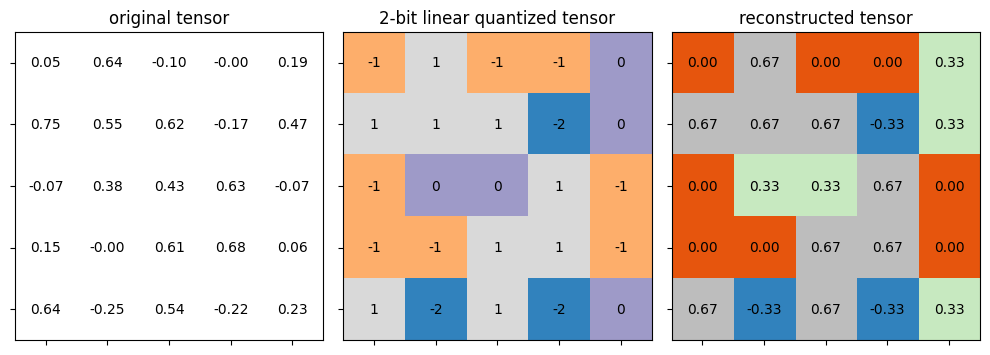

In [15]:
test_linear_quantize()

## **Question 2** (15 pts)

Now we have to determine the scaling factor $S$ and zero point $Z$ for linear quantization.

Recall that [linear quantization](https://arxiv.org/pdf/1712.05877.pdf) can be represented as

$r = S(q-Z)$

### **Question 2.1**: Scale (2 pts)

Linear quantization projects the floating point range [*fp_min*, *fp_max*] to the quantized range [*quantized_min*, *quantized_max*]. That is to say,

> $r_{\mathrm{max}} = S(q_{\mathrm{max}}-Z)$
>
> $r_{\mathrm{min}} = S(q_{\mathrm{min}}-Z)$


**Please select the correct answer and delete the wrong answers in the next text cell.**





> $S=(r_{\mathrm{max}} - r_{\mathrm{min}}) / (q_{\mathrm{max}} - q_{\mathrm{min}})$



There are different approaches to determine the $r_{\mathrm{min}}$ and  $r_{\mathrm{max}}$ of a floating point tensor `fp_tensor`.

*   The most common method is directly using the minimum and maximum value of `fp_tensor`.
*   Another widely used method is minimizing Kullback-Leibler-J divergence to determine the *fp_max*.

### **Question 2.2**: zero point (2 pts)

Once we determine the scaling factor $S$, we can directly use the relationship between $r_{\mathrm{min}}$ and $q_{\mathrm{min}}$ to calculate the zero point $Z$.

**Please select the correct answer and delete the wrong answers in the next text cell.**

> $Z = q_{\mathrm{min}} - r_{\mathrm{min}} / S$


### **Question 2.3** (11 pts)

Please complete the following function for calculating the scale $S$ and zero point $Z$ from floating point tensor $r$.


In [16]:
def get_quantization_scale_and_zero_point(fp_tensor, bitwidth):
    """
    get quantization scale for single tensor
    :param fp_tensor: [torch.(cuda.)Tensor] floating tensor to be quantized
    :param bitwidth: [int] quantization bit width
    :return:
        [float] scale
        [int] zero_point
    """
    quantized_min, quantized_max = get_quantized_range(bitwidth)
    fp_max = fp_tensor.max().item()
    fp_min = fp_tensor.min().item()

    ############### YOUR CODE STARTS HERE ###############
    # hint: one line of code for calculating scale
    scale = (fp_max - fp_min) / (quantized_max - quantized_min)
    # hint: one line of code for calculating zero_point
    zero_point = quantized_min - fp_min / scale
    ############### YOUR CODE ENDS HERE #################

    # clip the zero_point to fall in [quantized_min, quantized_max]
    if zero_point < quantized_min:
        zero_point = quantized_min
    elif zero_point > quantized_max:
        zero_point = quantized_max
    else: # convert from float to int using round()
        zero_point = round(zero_point)
    return scale, int(zero_point)

We now wrap  `linear_quantize()` in Question 4 and `get_quantization_scale_and_zero_point()` in Question 5 into one function.

In [17]:
def linear_quantize_feature(fp_tensor, bitwidth):
    """
    linear quantization for feature tensor
    :param fp_tensor: [torch.(cuda.)Tensor] floating feature to be quantized
    :param bitwidth: [int] quantization bit width
    :return:
        [torch.(cuda.)Tensor] quantized tensor
        [float] scale tensor
        [int] zero point
    """
    scale, zero_point = get_quantization_scale_and_zero_point(fp_tensor, bitwidth)
    quantized_tensor = linear_quantize(fp_tensor, bitwidth, scale, zero_point)
    return quantized_tensor, scale, zero_point

## **Question 3** (5 pts)

We can apply linear quantization on model weight.
Let's first see the distribution of weight values.

In [18]:
def plot_weight_distribution(model, bitwidth=32):
    # bins = (1 << bitwidth) if bitwidth <= 8 else 256
    if bitwidth <= 8:
        qmin, qmax = get_quantized_range(bitwidth)
        bins = np.arange(qmin, qmax + 2)
        align = 'left'
    else:
        bins = 256
        align = 'mid'
    fig, axes = plt.subplots(9,6, figsize=(20, 15))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            ax.hist(param.detach().view(-1).cpu(), bins=bins, density=True,
                    align=align, color = 'blue', alpha = 0.5,
                    edgecolor='black' if bitwidth <= 4 else None)
            if bitwidth <= 4:
                quantized_min, quantized_max = get_quantized_range(bitwidth)
                ax.set_xticks(np.arange(start=quantized_min, stop=quantized_max+1))
            ax.set_xlabel(name)
            ax.set_ylabel('density')
            plot_index += 1
    fig.suptitle(f'Histogram of Weights (bitwidth={bitwidth} bits)')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()

model = torch.load("mobilenetv2_for_quant.pth")
plot_weight_distribution(model)

As we can see from the histograms above, the distribution of weight values are nearly symmetric about 0 (except for the classifier in this case). Therefore, we usually make zero point $Z=0$ when quantizating the weights.

From $r = S(q-Z)$, we have

> $r_{\mathrm{max}} = S \cdot q_{\mathrm{max}}$

and then

> $S = r_{\mathrm{max}} / q_{\mathrm{max}}$

We directly use the maximum magnitude of weight values as $r_{\mathrm{max}}$.

In [ ]:
def get_quantization_scale_for_weight(weight, bitwidth):
    """
    get quantization scale for single tensor of weight
    :param weight: [torch.(cuda.)Tensor] floating weight to be quantized
    :param bitwidth: [integer] quantization bit width
    :return:
        [floating scalar] scale
    """
    # we just assume values in weight are symmetric
    # we also always make zero_point 0 for weight
    fp_max = max(weight.abs().max().item(), 5e-7)
    _, quantized_max = get_quantized_range(bitwidth)

    ############### YOUR CODE STARTS HERE ###############
    # hint: one line of code for calculating scale
    scale = fp_max / quantized_max
    ############### YOUR CODE ENDS HERE #################

    return scale

### Per-channel Linear Quantization

Recall that for 2D convolution, the weight tensor is a 4-D tensor in the shape of (num_output_channels, num_input_channels, kernel_height, kernel_width).

Intensive experiments show that using the different scaling factors $S$ and zero points $Z$ for different output channels will perform better. Therefore, we have to determine scaling factor $S$ and zero point $Z$ for the subtensor of each output channel independently.

In [ ]:
def linear_quantize_weight_per_channel(tensor, bitwidth):
    """
    linear quantization for weight tensor
        using different scales and zero_points for different output channels
    :param tensor: [torch.(cuda.)Tensor] floating weight to be quantized
    :param bitwidth: [int] quantization bit width
    :return:
        [torch.(cuda.)Tensor] quantized tensor
        [torch.(cuda.)Tensor] scale tensor
        [int] zero point (which is always 0)
    """
    dim_output_channels = 0
    num_output_channels = tensor.shape[dim_output_channels]
    scale = torch.zeros(num_output_channels, device=tensor.device)
    for oc in range(num_output_channels):
        _subtensor = tensor.select(dim_output_channels, oc)
        _scale = get_quantization_scale_for_weight(_subtensor, bitwidth)
        scale[oc] = _scale
    scale_shape = [1] * tensor.dim()
    scale_shape[dim_output_channels] = -1
    scale = scale.view(scale_shape)
    quantized_tensor = linear_quantize(tensor, bitwidth, scale, zero_point=0)
    return quantized_tensor, scale, 0

### A Quick Peek at Linear Quantization on Weights

Now let's have a peek on the weight distribution and model size when applying linear quantization on weights with different bitwidths.

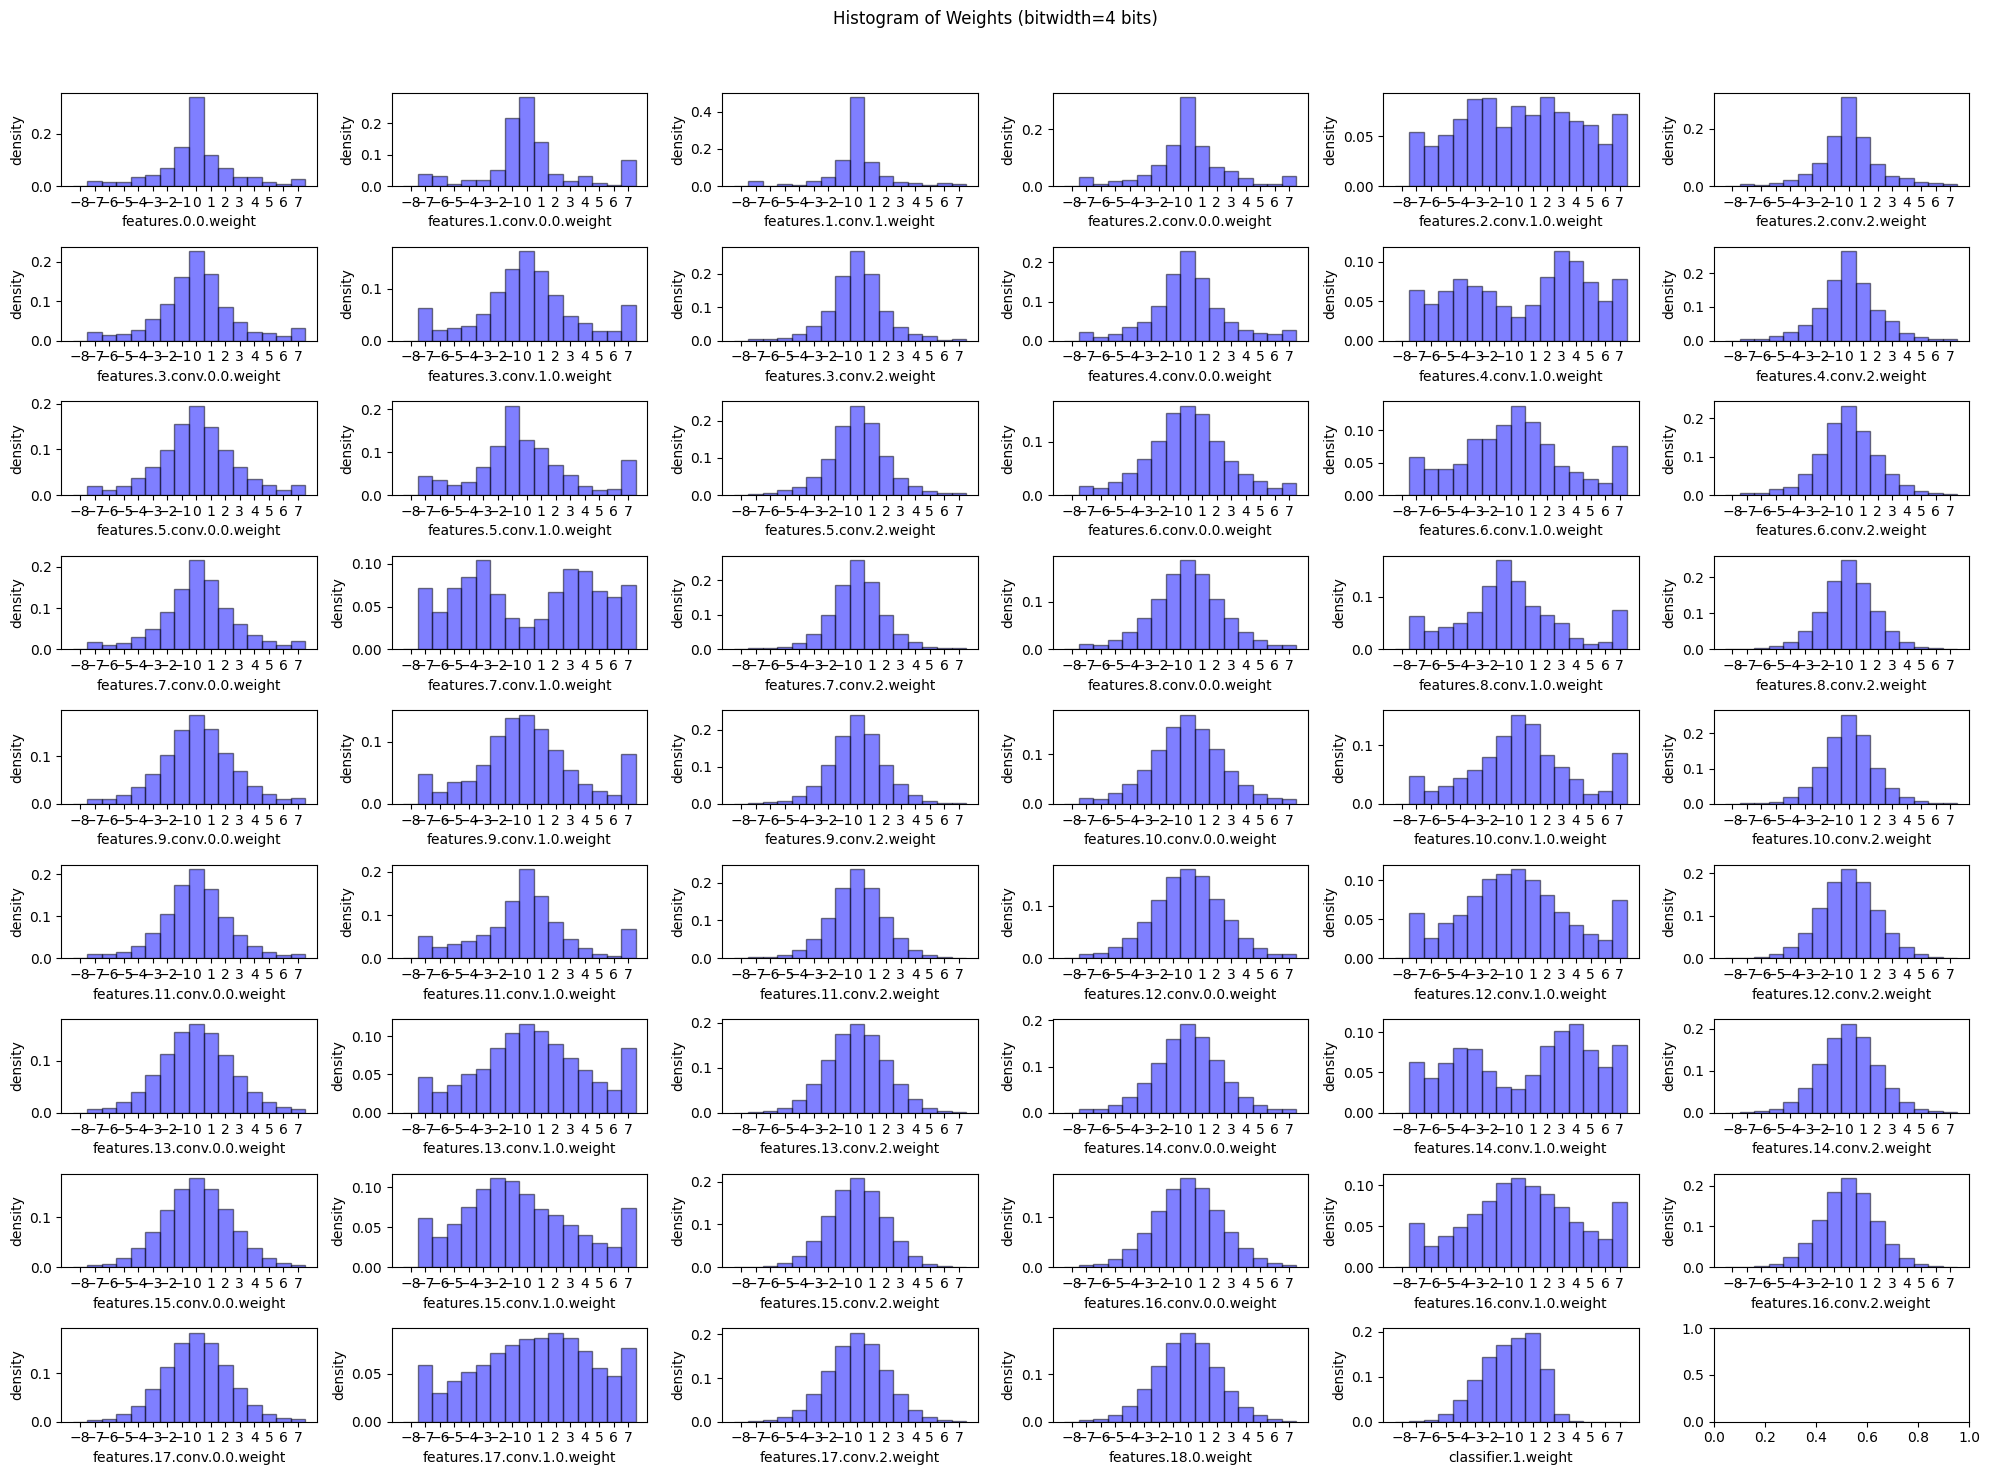

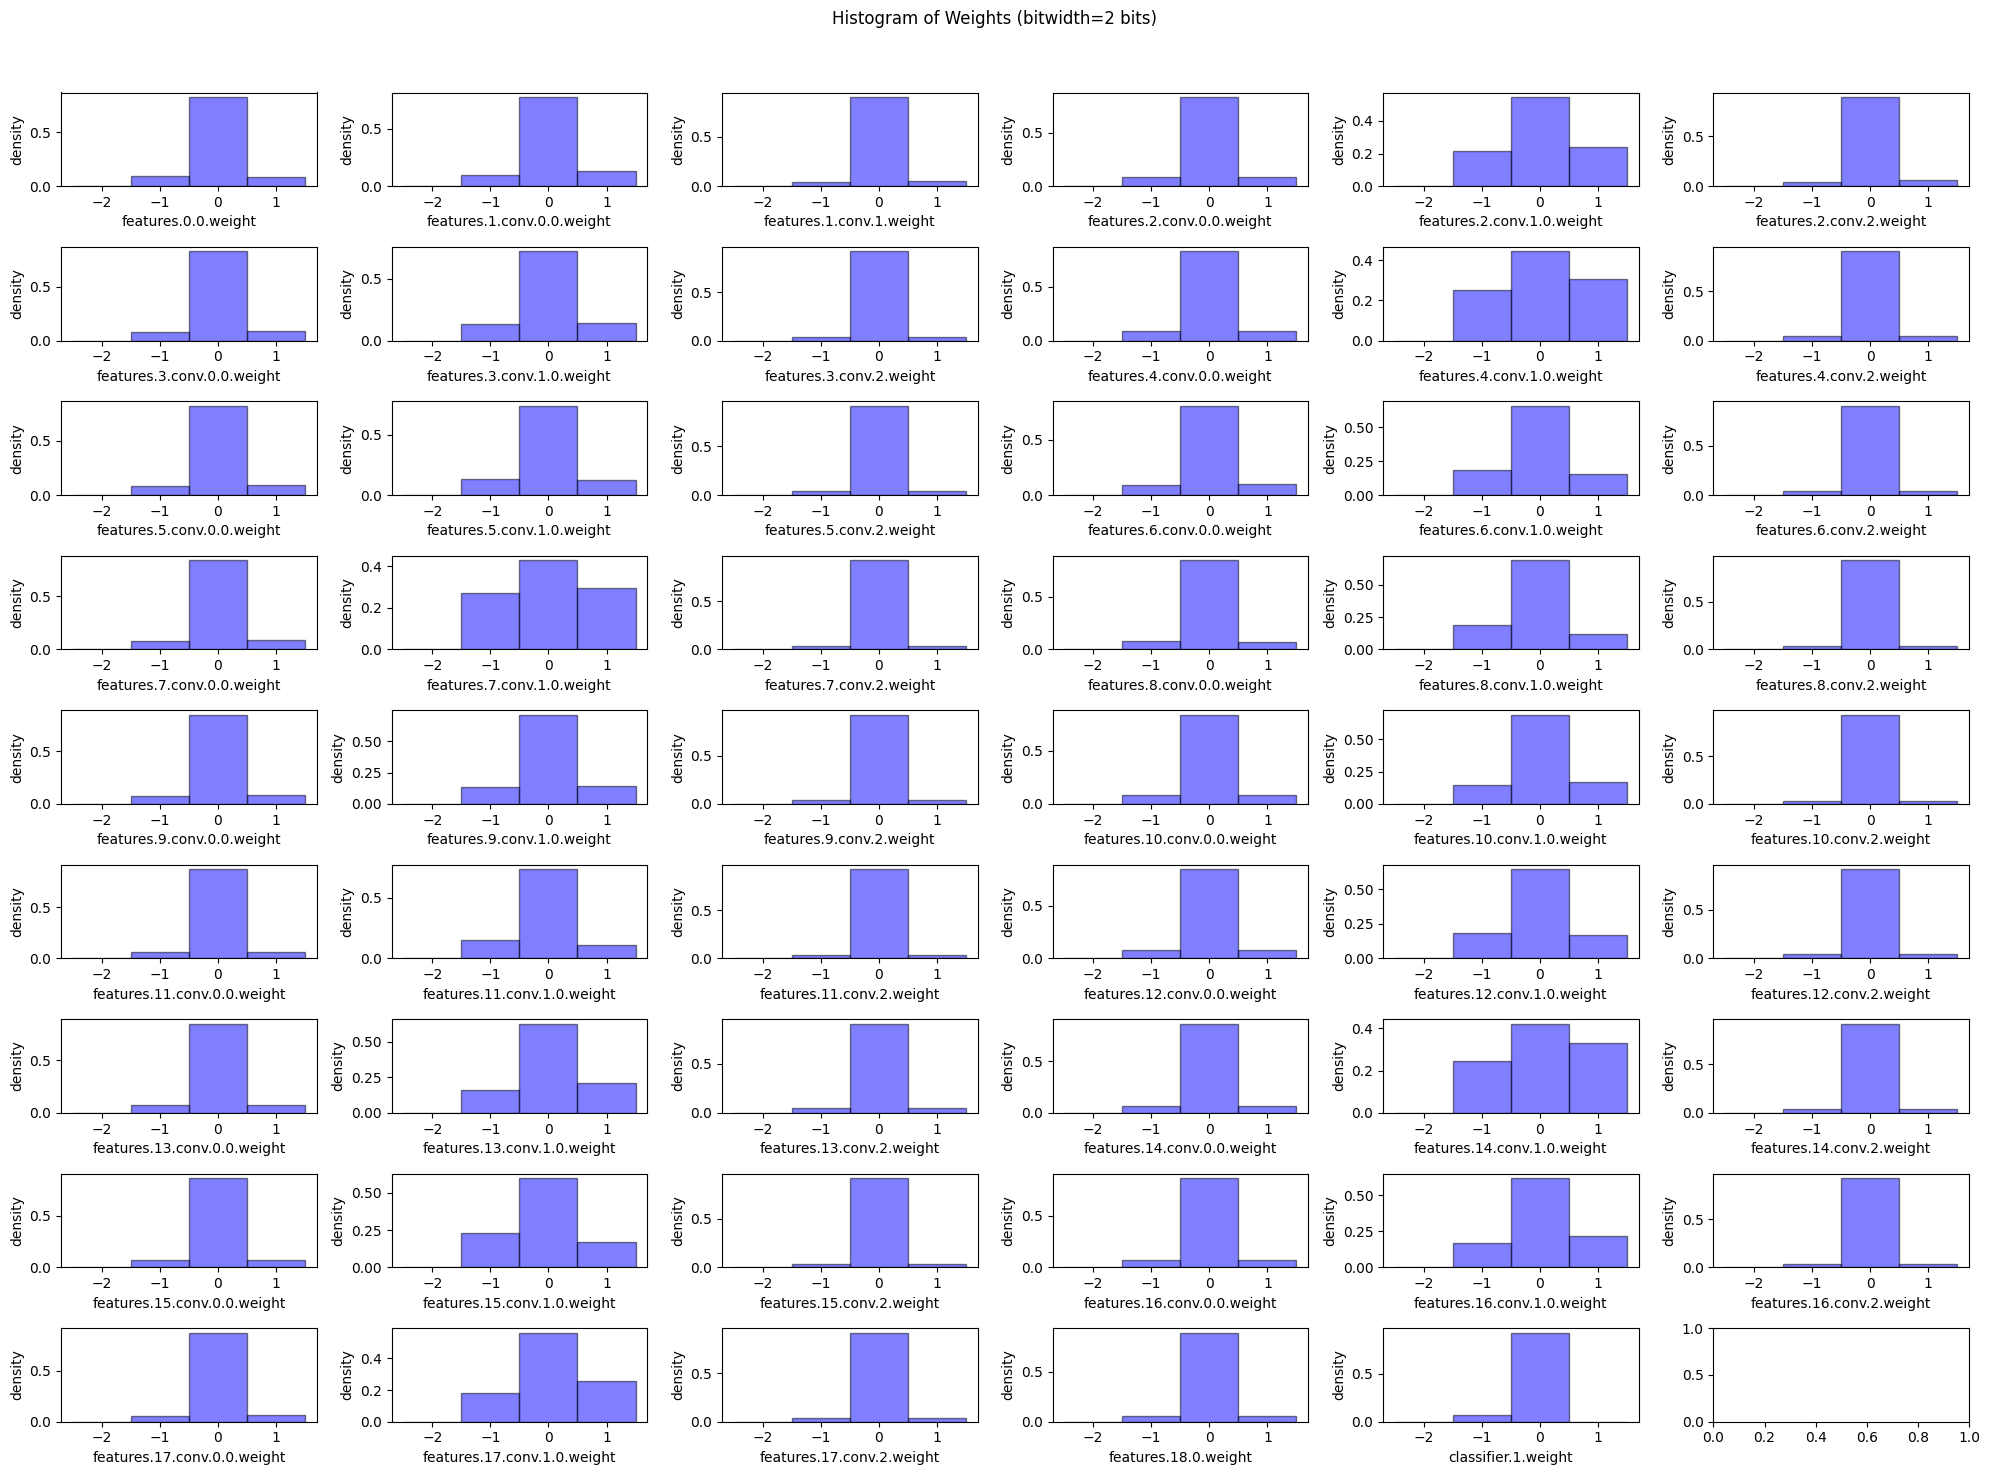

In [ ]:

@torch.no_grad()
def peek_linear_quantization():
    model = torch.load("mobilenetv2_for_quant.pth")
    for bitwidth in [4, 2]:
        for name, param in model.named_parameters():
            if param.dim() > 1:
                quantized_param, scale, zero_point = \
                    linear_quantize_weight_per_channel(param, bitwidth)
                param.copy_(quantized_param)
        plot_weight_distribution(model, bitwidth)
        model = torch.load("mobilenetv2_for_quant.pth")


peek_linear_quantization()

## **Quantized Inference**

After quantization, the inference of convolution and fully-connected layers also change.

Recall that $r = S(q-Z)$, and we have

> $r_{\mathrm{input}} = S_{\mathrm{input}}(q_{\mathrm{input}}-Z_{\mathrm{input}})$
>
> $r_{\mathrm{weight}} = S_{\mathrm{weight}}(q_{\mathrm{weight}}-Z_{\mathrm{weight}})$
>
> $r_{\mathrm{bias}} = S_{\mathrm{bias}}(q_{\mathrm{bias}}-Z_{\mathrm{bias}})$

Since $Z_{\mathrm{weight}}=0$, $r_{\mathrm{weight}} = S_{\mathrm{weight}}q_{\mathrm{weight}}$.

The floating point convolution can be written as,

> $r_{\mathrm{output}} = \mathrm{CONV}[r_{\mathrm{input}}, r_{\mathrm{weight}}] + r_{\mathrm{bias}}\\
\;\;\;\;\;\;\;\;= \mathrm{CONV}[S_{\mathrm{input}}(q_{\mathrm{input}}-Z_{\mathrm{input}}), S_{\mathrm{weight}}q_{\mathrm{weight}}] + S_{\mathrm{bias}}(q_{\mathrm{bias}}-Z_{\mathrm{bias}})\\
\;\;\;\;\;\;\;\;= \mathrm{CONV}[q_{\mathrm{input}}-Z_{\mathrm{input}}, q_{\mathrm{weight}}]\cdot (S_{\mathrm{input}} \cdot S_{\mathrm{weight}}) + S_{\mathrm{bias}}(q_{\mathrm{bias}}-Z_{\mathrm{bias}})$

To further simplify the computation, we could let

> $Z_{\mathrm{bias}} = 0$
>
> $S_{\mathrm{bias}} = S_{\mathrm{input}} \cdot S_{\mathrm{weight}}$

so that

> $r_{\mathrm{output}} = (\mathrm{CONV}[q_{\mathrm{input}}-Z_{\mathrm{input}}, q_{\mathrm{weight}}] + q_{\mathrm{bias}})\cdot (S_{\mathrm{input}} \cdot S_{\mathrm{weight}})$
> $\;\;\;\;\;\;\;\;= (\mathrm{CONV}[q_{\mathrm{input}}, q_{\mathrm{weight}}] - \mathrm{CONV}[Z_{\mathrm{input}}, q_{\mathrm{weight}}] + q_{\mathrm{bias}})\cdot (S_{\mathrm{input}}S_{\mathrm{weight}})$

Since
> $r_{\mathrm{output}} = S_{\mathrm{output}}(q_{\mathrm{output}}-Z_{\mathrm{output}})$

we have
> $S_{\mathrm{output}}(q_{\mathrm{output}}-Z_{\mathrm{output}}) = (\mathrm{CONV}[q_{\mathrm{input}}, q_{\mathrm{weight}}] - \mathrm{CONV}[Z_{\mathrm{input}}, q_{\mathrm{weight}}] + q_{\mathrm{bias}})\cdot (S_{\mathrm{input}} S_{\mathrm{weight}})$

and thus
> $q_{\mathrm{output}} = (\mathrm{CONV}[q_{\mathrm{input}}, q_{\mathrm{weight}}] - \mathrm{CONV}[Z_{\mathrm{input}}, q_{\mathrm{weight}}] + q_{\mathrm{bias}})\cdot (S_{\mathrm{input}}S_{\mathrm{weight}} / S_{\mathrm{output}}) + Z_{\mathrm{output}}$

Since $Z_{\mathrm{input}}$, $q_{\mathrm{weight}}$, $q_{\mathrm{bias}}$ are determined before inference, let

> $Q_{\mathrm{bias}} = q_{\mathrm{bias}} - \mathrm{CONV}[Z_{\mathrm{input}}, q_{\mathrm{weight}}]$

we have

> $q_{\mathrm{output}} = (\mathrm{CONV}[q_{\mathrm{input}}, q_{\mathrm{weight}}] + Q_{\mathrm{bias}}) \cdot (S_{\mathrm{input}}S_{\mathrm{weight}} / S_{\mathrm{output}}) + Z_{\mathrm{output}}$

Similarily, for fully-connected layer, we have

> $q_{\mathrm{output}} = (\mathrm{Linear}[q_{\mathrm{input}}, q_{\mathrm{weight}}] + Q_{\mathrm{bias}})\cdot (S_{\mathrm{input}} \cdot S_{\mathrm{weight}} / S_{\mathrm{output}}) + Z_{\mathrm{output}}$

where

> $Q_{\mathrm{bias}} = q_{\mathrm{bias}} - \mathrm{Linear}[Z_{\mathrm{input}}, q_{\mathrm{weight}}]$

## **Question** 4 (5 pts)

Please complete the following function for linear quantizing the bias.

**Hint**:

From the above deduction, we know that

> $Z_{\mathrm{bias}} = 0$
>
> $S_{\mathrm{bias}} = S_{\mathrm{input}} \cdot S_{\mathrm{weight}}$

In [ ]:
def linear_quantize_bias_per_output_channel(bias, weight_scale, input_scale):
    """
    linear quantization for single bias tensor
        quantized_bias = fp_bias / bias_scale
    :param bias: [torch.FloatTensor] bias weight to be quantized
    :param weight_scale: [float or torch.FloatTensor] weight scale tensor
    :param input_scale: [float] input scale
    :return:
        [torch.IntTensor] quantized bias tensor
    """
    assert(bias.dim() == 1)
    assert(bias.dtype == torch.float)
    assert(isinstance(input_scale, float))
    if isinstance(weight_scale, torch.Tensor):
        assert(weight_scale.dtype == torch.float)
        weight_scale = weight_scale.view(-1)
        assert(bias.numel() == weight_scale.numel())

    ############### YOUR CODE STARTS HERE ###############
    # hint: one line of code
    bias_scale = input_scale * weight_scale
    ############### YOUR CODE ENDS HERE #################

    quantized_bias = linear_quantize(bias, 32, bias_scale,
                        zero_point=0, dtype=torch.int32)

    return quantized_bias, bias_scale, 0

## **Question 5** (15 pts)

*Quantized Fully-Connected Layer*

For quantized fully-connected layer, we first precompute $Q_{\mathrm{bias}}$. Recall that $Q_{\mathrm{bias}} = q_{\mathrm{bias}} - \mathrm{Linear}[Z_{\mathrm{input}}, q_{\mathrm{weight}}]$.

In [ ]:
def shift_quantized_linear_bias(quantized_bias, quantized_weight, input_zero_point):
    """
    shift quantized bias to incorporate input_zero_point for nn.Linear
        shifted_quantized_bias = quantized_bias - Linear(input_zero_point, quantized_weight)
    :param quantized_bias: [torch.IntTensor] quantized bias (torch.int32)
    :param quantized_weight: [torch.CharTensor] quantized weight (torch.int8)
    :param input_zero_point: [int] input zero point
    :return:
        [torch.IntTensor] shifted quantized bias tensor
    """
    assert(quantized_bias.dtype == torch.int32)
    assert(isinstance(input_zero_point, int))
    return quantized_bias - quantized_weight.sum(1).to(torch.int32) * input_zero_point

Please complete the following quantized fully-connected layer inference function.

**Hint**:

> $q_{\mathrm{output}} = (\mathrm{Linear}[q_{\mathrm{input}}, q_{\mathrm{weight}}] + Q_{\mathrm{bias}})\cdot (S_{\mathrm{input}} S_{\mathrm{weight}} / S_{\mathrm{output}}) + Z_{\mathrm{output}}$

In [ ]:
def quantized_linear(input, weight, bias, feature_bitwidth, weight_bitwidth,
                     input_zero_point, output_zero_point,
                     input_scale, weight_scale, output_scale):
    """
    quantized fully-connected layer
    :param input: [torch.CharTensor] quantized input (torch.int8)
    :param weight: [torch.CharTensor] quantized weight (torch.int8)
    :param bias: [torch.IntTensor] shifted quantized bias or None (torch.int32)
    :param feature_bitwidth: [int] quantization bit width of input and output
    :param weight_bitwidth: [int] quantization bit width of weight
    :param input_zero_point: [int] input zero point
    :param output_zero_point: [int] output zero point
    :param input_scale: [float] input feature scale
    :param weight_scale: [torch.FloatTensor] weight per-channel scale
    :param output_scale: [float] output feature scale
    :return:
        [torch.CharIntTensor] quantized output feature (torch.int8)
    """
    assert(input.dtype == torch.int8)
    assert(weight.dtype == input.dtype)
    assert(bias is None or bias.dtype == torch.int32)
    assert(isinstance(input_zero_point, int))
    assert(isinstance(output_zero_point, int))
    assert(isinstance(input_scale, float))
    assert(isinstance(output_scale, float))
    assert(weight_scale.dtype == torch.float)

    # Step 1: integer-based fully-connected (8-bit multiplication with 32-bit accumulation)
    if 'cpu' in input.device.type:
        # use 32-b MAC for simplicity
        output = torch.nn.functional.linear(input.to(torch.int32), weight.to(torch.int32), bias)
    else:
        # current version pytorch does not yet support integer-based linear() on GPUs
        output = torch.nn.functional.linear(input.float(), weight.float(), bias.float())

    ############### YOUR CODE STARTS HERE ###############
    # Step 2: scale the output
    #         hint: 1. scales are floating numbers, we need to convert output to float as well
    #               2. the shape of weight scale is [oc, 1, 1, 1] while the shape of output is [batch_size, oc]
    output = output.float() * (input_scale * weight_scale.view(-1) / output_scale)

    # Step 3: shift output by output_zero_point
    #         hint: one line of code
    output += output_zero_point
    ############### YOUR CODE ENDS HERE #################

    # Make sure all value lies in the bitwidth-bit range
    output = output.round().clamp(*get_quantized_range(feature_bitwidth)).to(torch.int8)
    return output

Let's verify the functionality of defined quantized fully connected layer.

* Test quantized_fc()
    target bitwidth: 2 bits
      batch size: 4
      input channels: 8
      output channels: 8
* Test passed.


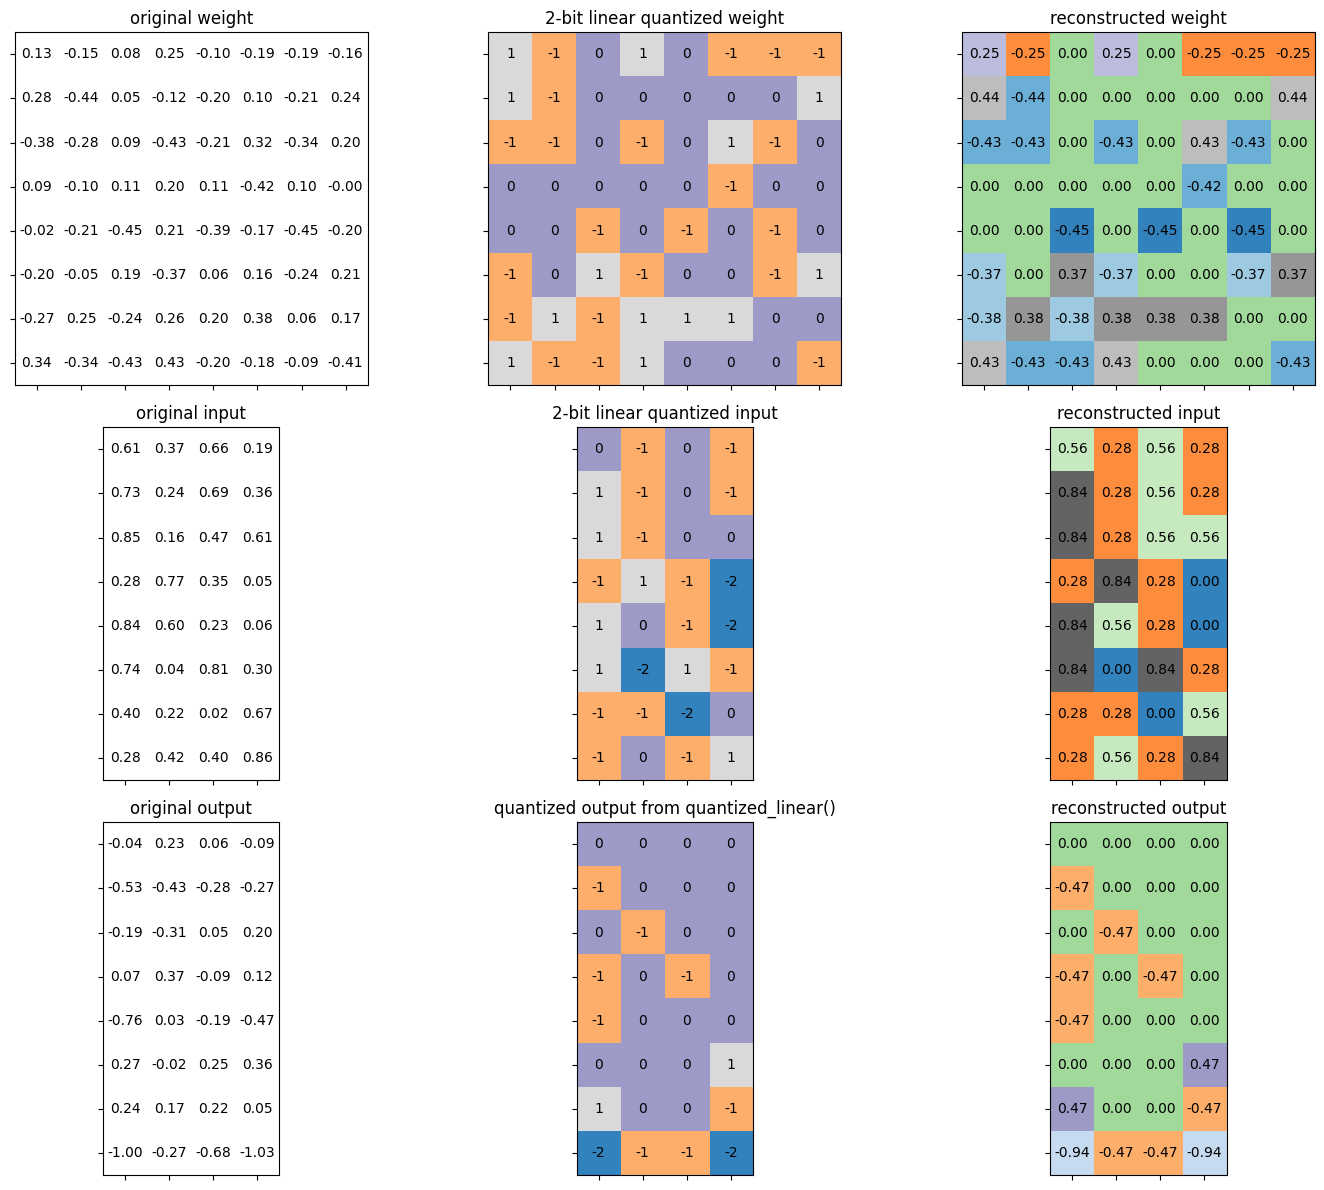

In [ ]:
test_quantized_fc()

## **Question 6** (15 pts)

*Quantized Convolution Layer*

For quantized convolution layer, we first precompute $Q_{\mathrm{bias}}$. Recall that $Q_{\mathrm{bias}} = q_{\mathrm{bias}} - \mathrm{CONV}[Z_{\mathrm{input}}, q_{\mathrm{weight}}]$.

In [ ]:
def shift_quantized_conv2d_bias(quantized_bias, quantized_weight, input_zero_point):
    """
    shift quantized bias to incorporate input_zero_point for nn.Conv2d
        shifted_quantized_bias = quantized_bias - Conv(input_zero_point, quantized_weight)
    :param quantized_bias: [torch.IntTensor] quantized bias (torch.int32)
    :param quantized_weight: [torch.CharTensor] quantized weight (torch.int8)
    :param input_zero_point: [int] input zero point
    :return:
        [torch.IntTensor] shifted quantized bias tensor
    """
    assert(quantized_bias.dtype == torch.int32)
    assert(isinstance(input_zero_point, int))
    return quantized_bias - quantized_weight.sum((1,2,3)).to(torch.int32) * input_zero_point

Please complete the following quantized convolution function.

**Hint**:
> $q_{\mathrm{output}} = (\mathrm{CONV}[q_{\mathrm{input}}, q_{\mathrm{weight}}] + Q_{\mathrm{bias}}) \cdot (S_{\mathrm{input}}S_{\mathrm{weight}} / S_{\mathrm{output}}) + Z_{\mathrm{output}}$


In [ ]:
def quantized_conv2d(input, weight, bias, feature_bitwidth, weight_bitwidth,
                     input_zero_point, output_zero_point,
                     input_scale, weight_scale, output_scale,
                     stride, padding, dilation, groups):
    """
    quantized 2d convolution
    :param input: [torch.CharTensor] quantized input (torch.int8)
    :param weight: [torch.CharTensor] quantized weight (torch.int8)
    :param bias: [torch.IntTensor] shifted quantized bias or None (torch.int32)
    :param feature_bitwidth: [int] quantization bit width of input and output
    :param weight_bitwidth: [int] quantization bit width of weight
    :param input_zero_point: [int] input zero point
    :param output_zero_point: [int] output zero point
    :param input_scale: [float] input feature scale
    :param weight_scale: [torch.FloatTensor] weight per-channel scale
    :param output_scale: [float] output feature scale
    :return:
        [torch.(cuda.)CharTensor] quantized output feature
    """
    assert(len(padding) == 4)
    assert(input.dtype == torch.int8)
    assert(weight.dtype == input.dtype)
    assert(bias is None or bias.dtype == torch.int32)
    assert(isinstance(input_zero_point, int))
    assert(isinstance(output_zero_point, int))
    assert(isinstance(input_scale, float))
    assert(isinstance(output_scale, float))
    assert(weight_scale.dtype == torch.float)

    # Step 1: calculate integer-based 2d convolution (8-bit multiplication with 32-bit accumulation)
    input = torch.nn.functional.pad(input, padding, 'constant', input_zero_point)
    if 'cpu' in input.device.type:
        # use 32-b MAC for simplicity
        output = torch.nn.functional.conv2d(input.to(torch.int32), weight.to(torch.int32), None, stride, 0, dilation, groups)
    else:
        # current version pytorch does not yet support integer-based conv2d() on GPUs
        output = torch.nn.functional.conv2d(input.float(), weight.float(), None, stride, 0, dilation, groups)
        output = output.round().to(torch.int32)
    if bias is not None:
        output = output + bias.view(1, -1, 1, 1)

    ############### YOUR CODE STARTS HERE ###############
    # hint: this code block should be the very similar to quantized_linear()

    # Step 2: scale the output
    #         hint: 1. scales are floating numbers, we need to convert output to float as well
    #               2. the shape of weight scale is [oc, 1, 1, 1] while the shape of output is [batch_size, oc, height, width]
    output = output.float() * (input_scale * weight_scale.view(1, -1, 1, 1) / output_scale)

    # Step 3: shift output by output_zero_point
    #         hint: one line of code
    output += output_zero_point
    ############### YOUR CODE ENDS HERE #################

    # Make sure all value lies in the bitwidth-bit range
    output = output.round().clamp(*get_quantized_range(feature_bitwidth)).to(torch.int8)
    return output

Let's verify the functionality of defined quantized convolution layer.

* Test quantized_conv2d()
    target bitwidth: 2 bits
      input channels: 2
      output channels: 2
* Test passed.


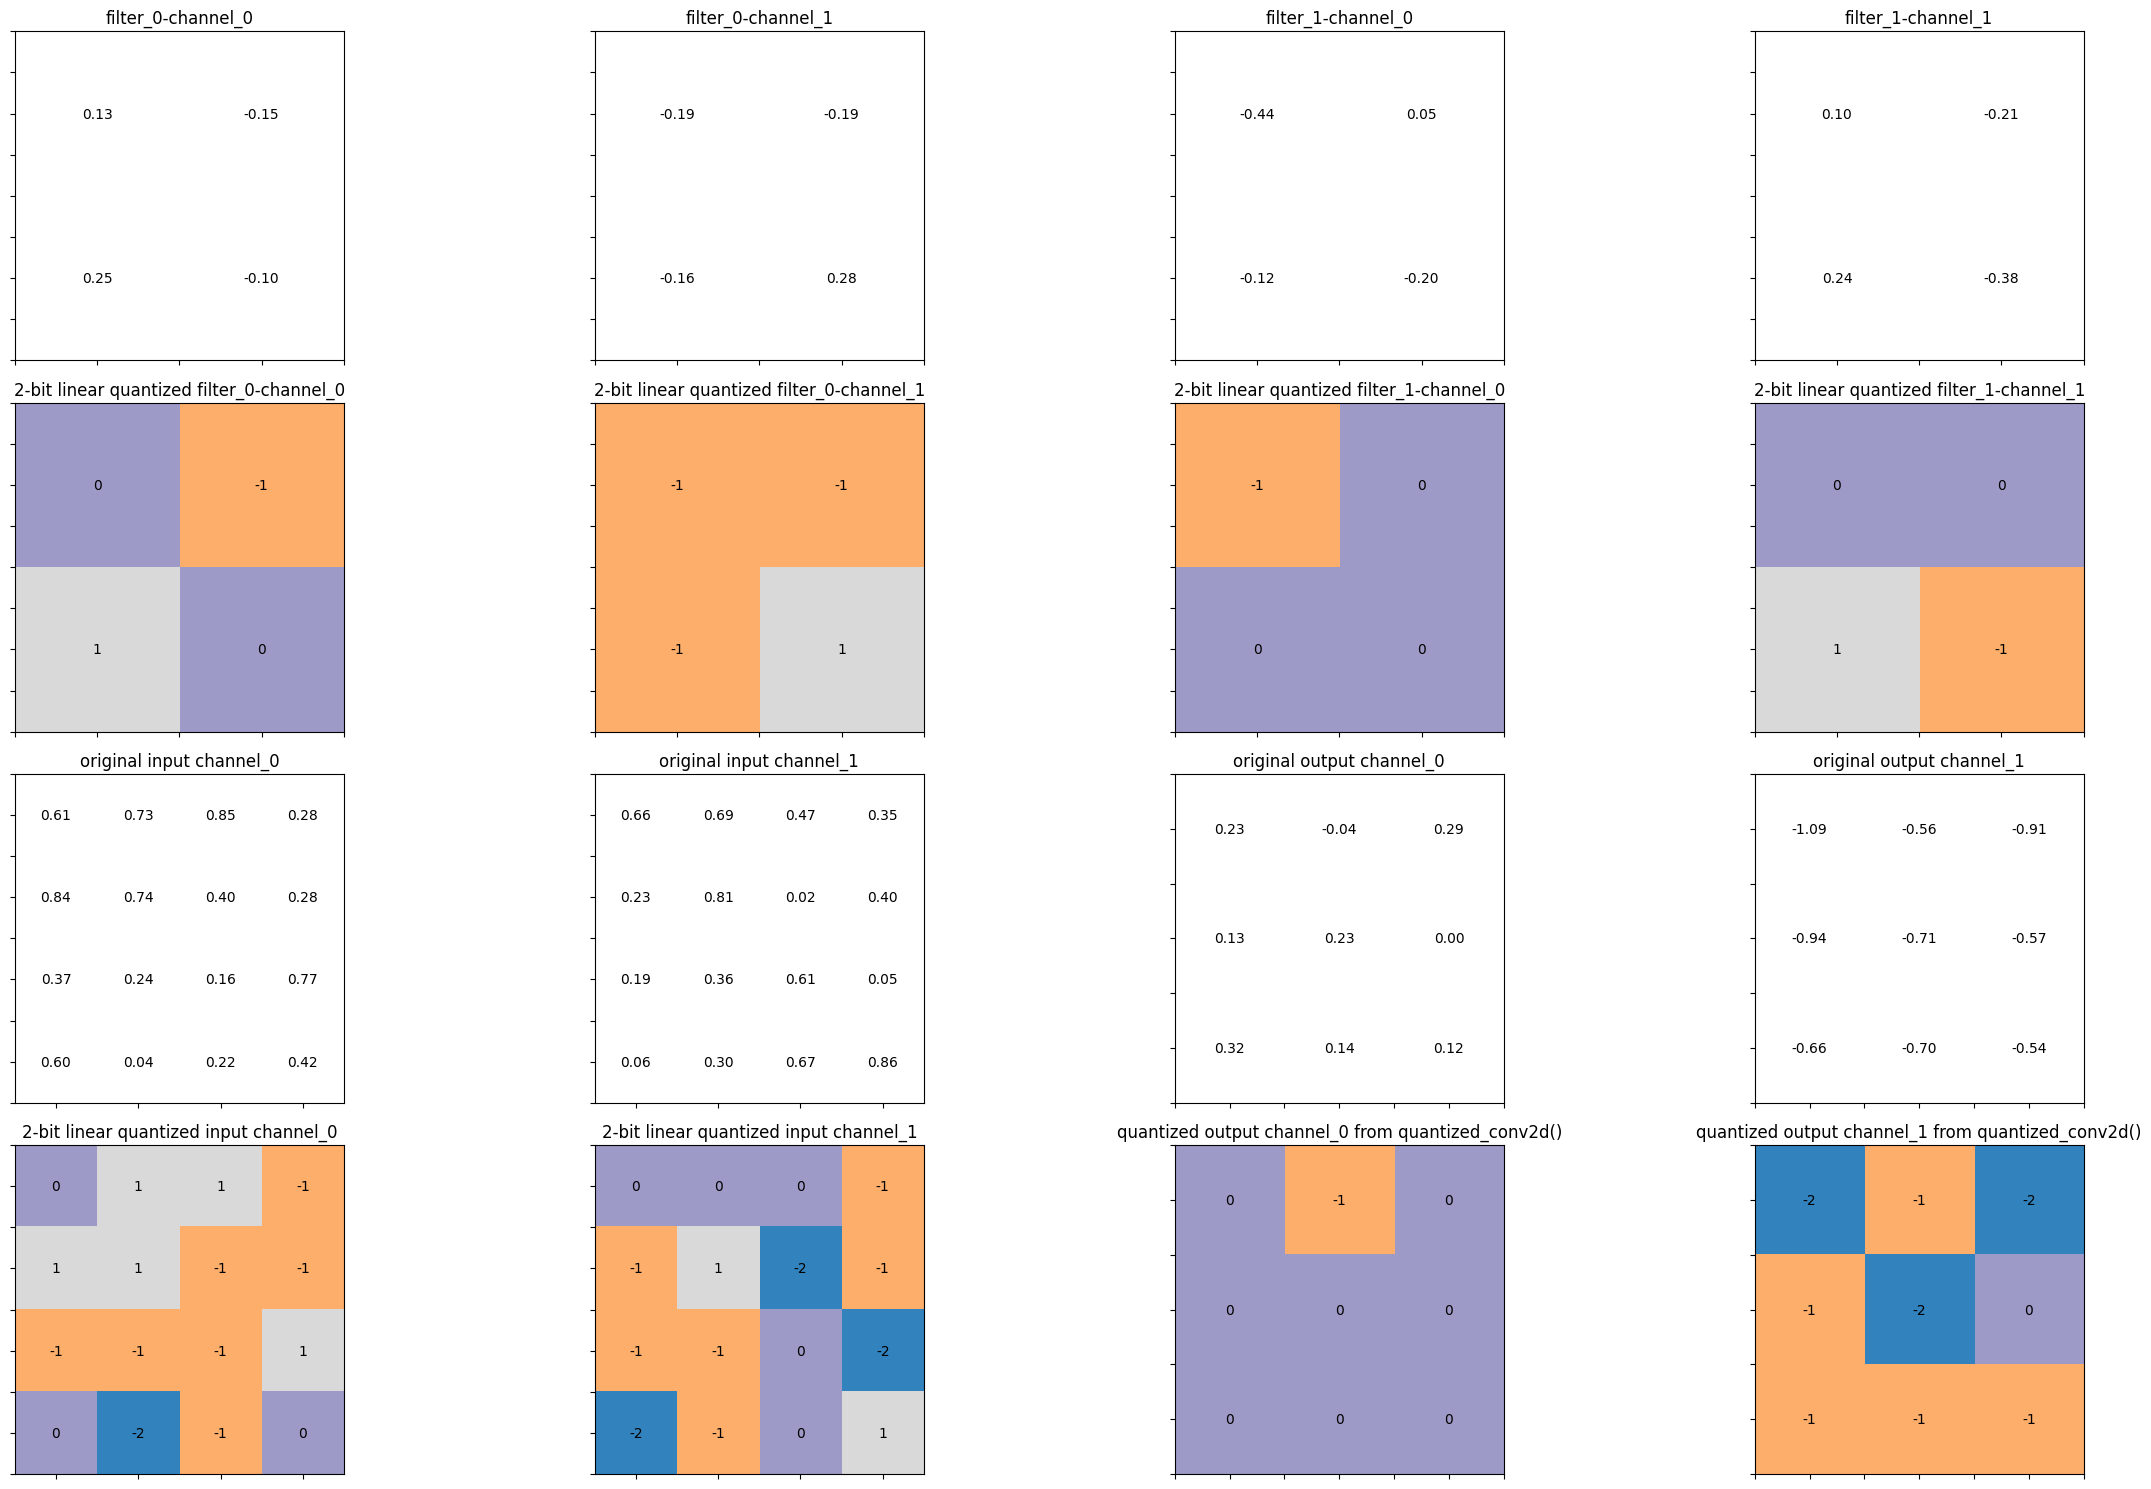

In [ ]:
test_quantized_conv()

# Part2: Quantize MobileNetV2 and Export

Below shows the steps of how to quantize & convert the model.  For more details, refer to [Quantization-Aware Training](https://pytorch.org/tutorials/prototype/pt2e_quant_qat.html)and[Post Training Quantization](https://pytorch.org/tutorials/prototype/pt2e_quant_ptq.html). You may have to run it using your own machine.

***The code blocks below doesen't have to be executed when you are submitting this file.***

 $$
        Score = (10 \times Step  function(Accuracy-0.88)+ 20 \times \dfrac{Accuracy - 0.88}{0.96 - 0.88})
$$

1. Load **mobilenet_v2** with 96.3% accuracy on CIFAR10. (Link of the model is written in the spec of lab3)

In [25]:
from torch._export import capture_pre_autograd_graph

from torch.ao.quantization.quantize_pt2e import (
  prepare_pt2e,
  convert_pt2e,
  prepare_qat_pt2e
)

from torch.ao.quantization.quantizer.xnnpack_quantizer import (
  XNNPACKQuantizer,
  get_symmetric_quantization_config,
)

In [26]:
import torch
from torchvision.models import mobilenet_v2
# from torchvision.models.quantization import mobilenet_v2

model = torch.load('mobilenetv2_for_quant.pth')

2. Quantize the model using XNNPACKQuantizer, you can choose either Post Training Quantization or Quantization-Aware Training.

In [27]:
import numpy as np
import torch
import torchvision
from torch import nn
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader
from torchprofile import profile_macs
from torchvision.datasets import *
from torchvision.transforms import *
from tqdm.auto import tqdm
import os 

def prepare_data(batch_size):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize images to match MobileNet input size
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    train_set = CIFAR10(root='./data', train=True, download=True, transform=transform)
    test_set = CIFAR10(root='./data', train=False, download=True, transform=transform)
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False,drop_last=True)
    return train_loader, test_loader

In [28]:
def evaluate_model(model, data_loader,device):

    model.to(device)
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Accuracy of the model on the test images: {accuracy}%')
    return accuracy

def train_one_epoch(model, criterion, optimizer, data_loader, device):

    cnt = 0

    for image, target in data_loader:
        cnt += 1
        image, target = image.to(device), target.to(device)
        output = model(image)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return

def print_size_of_model(model):
    torch.save(model.state_dict(), "temp.p")
    print('Size (MB):', os.path.getsize("temp.p")/1e6)
    os.remove('temp.p')

In [29]:
batch_size = 64
train_loader, test_loader = prepare_data(batch_size)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.eval()
model.to(device)

print_size_of_model(model)
evaluate_model(model, test_loader,device)

Files already downloaded and verified
Files already downloaded and verified
Size (MB): 9.173828
Accuracy of the model on the test images: 96.30408653846153%


96.30408653846153

In [30]:
# def quantize_ptq_model(model: nn.Module) -> None:
#     ############### YOUR CODE STARTS HERE ###############


#     # Step 1. program capture
#     model.eval()
#     from torch._export import capture_pre_autograd_graph

#     example_inputs = (torch.rand(1, 3, 224, 224),)
#     exported_model = capture_pre_autograd_graph(model, example_inputs)

#     # Step 2. set quantizatizer
#     # prepare_pt2e folds BatchNorm operators into preceding Conv2d operators, and inserts observers in appropriate places in the model.
#     from torch.ao.quantization.quantizer.xnnpack_quantizer import (
#     XNNPACKQuantizer,
#     get_symmetric_quantization_config,
#     )
#     quantizer = XNNPACKQuantizer()
#     quantizer.set_global(get_symmetric_quantization_config())
#     # Step 3. prepare pt2e
#     prepared_model = prepare_pt2e(exported_model, quantizer)
#     print(prepared_model.graph)

#     def calibrate(model, data_loader):
#         model.eval()
#         with torch.no_grad():
#             for image, target in data_loader:
#                 model(image)
#     calibrate(prepared_model, data_loader_test) 
#     # Step 4. convert model
#     quantized_model = convert_pt2e(prepared_model)
#     print(quantized_model)

#     ############### YOUR CODE ENDS HERE #################
#     return quantized_model


# ptq_model = quantize_ptq_model(model)
# torch.ao.quantization.move_exported_model_to_eval(qte_model)

In [32]:
import torch
import torch.nn as nn
from torchvision.models import mobilenet_v2
from torch._export import capture_pre_autograd_graph
from torch.ao.quantization.quantize_pt2e import prepare_qat_pt2e
from torch._export import capture_pre_autograd_graph
from torch.ao.quantization.quantizer.xnnpack_quantizer import (
    XNNPACKQuantizer,
    get_symmetric_quantization_config,
)


def prepare_qat_model(model: nn.Module) -> None:
    ############### YOUR CODE STARTS HERE ###############

    # Step 1. program capture
    batch_size = 64
    example_inputs = (torch.rand(batch_size, 3, 224, 224),)

    
    model = capture_pre_autograd_graph(model, example_inputs)



    # Step 2. set quantizatizer
    quantizer = XNNPACKQuantizer()
    quantizer.set_global(get_symmetric_quantization_config(is_qat=True))

    # Step 3. prepare qat pt2e
    model = prepare_qat_pt2e(model, quantizer)
    print(model)


    ############### YOUR CODE ENDS HERE #################

    return model

In [34]:
from tqdm import tqdm
import copy

############### YOUR CODE STARTS HERE ###############
num_epochs = 5  # Adjust as necessary based on the convergence rate observed during training
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
############### YOUR CODE ENDS HERE #################


num_observer_update_epochs = 2
num_batch_norm_update_epochs = 2
num_epochs_between_evals = 1

criterion = nn.CrossEntropyLoss()

model = torch.load('mobilenetv2_for_quant.pth', map_location="cpu")
prepared_model = prepare_qat_model(model)
prepared_model = prepared_model.to(device)

# QAT takes time and one needs to train over a few epochs.
for epoch in tqdm(range(num_epochs), desc='Training Epochs', unit='epoch'):
    train_one_epoch(prepared_model, criterion, optimizer, train_loader, device)

    # Optionally disable observer/batchnorm stats after certain number of epochs
    if epoch >= num_observer_update_epochs:
        print("Disabling observer for subseq epochs, epoch = ", epoch)
        prepared_model.apply(torch.ao.quantization.disable_observer)
    # if epoch >= num_batch_norm_update_epochs:
    #     print("Freezing BN for subseq epochs, epoch = ", epoch)
    #     for n in prepared_model.graph.nodes:
    #         # Args: input, weight, bias, running_mean, running_var, training, momentum, eps
    #         # set the `training` flag to False here to freeze BN stats
    #         if n.target in [
    #             torch.ops.aten._native_batch_norm_legit.default,
    #             torch.ops.aten.cudnn_batch_norm.default,
    #         ]:
    #             new_args = list(n.args)
    #             new_args[5] = False
    #             n.args = new_args
    #     prepared_model.recompile()

    # Check the quantized accuracy every N epochs

    if (epoch + 1) % num_epochs_between_evals == 0:
        prepared_model_copy = copy.deepcopy(prepared_model)
        quantized_model = convert_pt2e(prepared_model_copy)
        acc = evaluate_model(quantized_model, test_loader,device)
        print(f"Accuracy after epoch {epoch + 1}: {acc}%")


GraphModule(
  (activation_post_process_0): FusedMovingAvgObsFakeQuantize(
    fake_quant_enabled=tensor([1]), observer_enabled=tensor([1]), scale=tensor([1.]), zero_point=tensor([0], dtype=torch.int32), dtype=torch.int8, quant_min=-128, quant_max=127, qscheme=torch.per_tensor_affine, reduce_range=False
    (activation_post_process): MovingAverageMinMaxObserver(min_val=inf, max_val=-inf)
  )
  (activation_post_process_1): FusedMovingAvgObsFakeQuantize(
    fake_quant_enabled=tensor([1]), observer_enabled=tensor([1]), scale=tensor([1.]), zero_point=tensor([0], dtype=torch.int32), dtype=torch.int8, quant_min=-127, quant_max=127, qscheme=torch.per_tensor_symmetric, reduce_range=False
    (activation_post_process): MovingAverageMinMaxObserver(min_val=inf, max_val=-inf)
  )
  (activation_post_process_2): FusedMovingAvgObsFakeQuantize(
    fake_quant_enabled=tensor([1]), observer_enabled=tensor([1]), scale=tensor([1.]), zero_point=tensor([0], dtype=torch.int32), dtype=torch.int8, quant_min=-

Training Epochs:  20%|██        | 1/5 [05:37<22:29, 337.47s/epoch]

Accuracy of the model on the test images: 89.27283653846153%
Accuracy after epoch 1: 89.27283653846153%


Training Epochs:  40%|████      | 2/5 [11:05<16:35, 331.93s/epoch]

Accuracy of the model on the test images: 91.54647435897436%
Accuracy after epoch 2: 91.54647435897436%
Disabling observer for subseq epochs, epoch =  2


Training Epochs:  60%|██████    | 3/5 [16:14<10:42, 321.31s/epoch]

Accuracy of the model on the test images: 91.22596153846153%
Accuracy after epoch 3: 91.22596153846153%
Disabling observer for subseq epochs, epoch =  3


Training Epochs:  80%|████████  | 4/5 [21:23<05:16, 316.76s/epoch]

Accuracy of the model on the test images: 89.98397435897436%
Accuracy after epoch 4: 89.98397435897436%
Disabling observer for subseq epochs, epoch =  4


Training Epochs: 100%|██████████| 5/5 [26:35<00:00, 319.08s/epoch]

Accuracy of the model on the test images: 92.1474358974359%
Accuracy after epoch 5: 92.1474358974359%


# optuna fintuning 

In [36]:
import torch
from torch.optim import SGD
from tqdm import tqdm
import optuna
import copy


def objective(trial):
    
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
    momentum = trial.suggest_uniform('momentum', 0.5, 0.99)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-3)

    model = prepared_model  
    optimizer = SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    criterion = torch.nn.CrossEntropyLoss()  
    num_epochs = 3  

    for epoch in tqdm(range(num_epochs), desc='Training Epochs', unit='epoch'):
        train_one_epoch(model, criterion, optimizer, train_loader, device)
        
        if (epoch + 1) % num_epochs_between_evals == 0:
            model_copy = copy.deepcopy(model)
            quantized_model = convert_pt2e(model_copy) 
            acc = evaluate_model(quantized_model, test_loader, device)
    
    # Negative accuracy because Optuna tries to minimize the objective
    return -acc

# Create a study 
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)  

# Print the best parameters
print("Best trial:")
trial = study.best_trial
print(f"  Value: {-trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")



def train_model_with_hyperparams(lr, momentum, weight_decay, additional_epochs):
    model = prepared_model  # 
    optimizer = SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    criterion = torch.nn.CrossEntropyLoss()  

    for epoch in tqdm(range(additional_epochs), desc='Additional Training', unit='epoch'):
        train_one_epoch(model, criterion, optimizer, train_loader, device)

        if (epoch + 1) % num_epochs_between_evals == 0:
            model_copy = copy.deepcopy(model)
            quantized_model = convert_pt2e(model_copy)
            acc = evaluate_model(quantized_model, test_loader, device)
            print(f"Accuracy after additional epoch {epoch + 1}: {acc}%")

    return model  


# Retrieve the best hyperparameters
best_trial = study.best_trial
best_lr = best_trial.params['lr']
best_momentum = best_trial.params['momentum']
best_weight_decay = best_trial.params['weight_decay']

# Train the model for additional epochs using the best parameters found
additional_epochs = 10 
trained_model = train_model_with_hyperparams(best_lr, best_momentum, best_weight_decay, additional_epochs)


[I 2024-05-02 20:35:07,352] A new study created in memory with name: no-name-daa8c810-3228-4c24-980d-1ad04d1573c2
/tmp/ipykernel_373268/2579244630.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
/tmp/ipykernel_373268/2579244630.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  momentum = trial.suggest_uniform('momentum', 0.5, 0.99)
/tmp/ipykernel_373268/2579244630.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-

Training Epochs:  33%|███▎      | 1/3 [05:08<10:17, 308.96s/epoch]

Accuracy of the model on the test images: 92.52804487179488%


Training Epochs:  67%|██████▋   | 2/3 [10:14<05:06, 306.86s/epoch]

Accuracy of the model on the test images: 91.94711538461539%


Training Epochs: 100%|██████████| 3/3 [15:18<00:00, 306.32s/epoch]
[I 2024-05-02 20:50:26,319] Trial 0 finished with value: -92.4579326923077 and parameters: {'lr': 0.0002700811676349845, 'momentum': 0.7532868449710013, 'weight_decay': 1.8056089599693192e-05}. Best is trial 0 with value: -92.4579326923077.
/tmp/ipykernel_373268/2579244630.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
/tmp/ipykernel_373268/2579244630.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  momentum = trial.suggest_uniform('momentum', 0.5, 0.99)
/tmp/ipykernel_373268/2579244630.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

Accuracy of the model on the test images: 92.4579326923077%


Training Epochs:  33%|███▎      | 1/3 [05:04<10:09, 304.76s/epoch]

Accuracy of the model on the test images: 93.92027243589743%


Training Epochs:  67%|██████▋   | 2/3 [10:11<05:06, 306.01s/epoch]

Accuracy of the model on the test images: 93.6698717948718%


Training Epochs: 100%|██████████| 3/3 [15:19<00:00, 306.54s/epoch]
[I 2024-05-02 21:05:45,956] Trial 1 finished with value: -94.8417467948718 and parameters: {'lr': 0.0009573046511276252, 'momentum': 0.8840083591272349, 'weight_decay': 1.7053221673760034e-05}. Best is trial 1 with value: -94.8417467948718.
/tmp/ipykernel_373268/2579244630.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
/tmp/ipykernel_373268/2579244630.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  momentum = trial.suggest_uniform('momentum', 0.5, 0.99)
/tmp/ipykernel_373268/2579244630.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

Accuracy of the model on the test images: 94.8417467948718%


Training Epochs:  33%|███▎      | 1/3 [05:07<10:14, 307.07s/epoch]

Accuracy of the model on the test images: 94.1806891025641%


Training Epochs:  67%|██████▋   | 2/3 [10:14<05:07, 307.48s/epoch]

Accuracy of the model on the test images: 94.44110576923077%


Training Epochs: 100%|██████████| 3/3 [15:23<00:00, 307.94s/epoch]
[I 2024-05-02 21:21:09,791] Trial 2 finished with value: -94.42107371794872 and parameters: {'lr': 0.002026283279306294, 'momentum': 0.7072417791038454, 'weight_decay': 1.1561812642513452e-05}. Best is trial 1 with value: -94.8417467948718.
/tmp/ipykernel_373268/2579244630.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
/tmp/ipykernel_373268/2579244630.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  momentum = trial.suggest_uniform('momentum', 0.5, 0.99)
/tmp/ipykernel_373268/2579244630.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

Accuracy of the model on the test images: 94.42107371794872%


Training Epochs:  33%|███▎      | 1/3 [05:20<10:40, 320.25s/epoch]

Accuracy of the model on the test images: 94.81169871794872%


Training Epochs:  67%|██████▋   | 2/3 [10:51<05:26, 326.86s/epoch]

Accuracy of the model on the test images: 94.52123397435898%


Training Epochs: 100%|██████████| 3/3 [16:11<00:00, 323.96s/epoch]
[I 2024-05-02 21:37:21,694] Trial 3 finished with value: -94.74158653846153 and parameters: {'lr': 7.941693880607991e-05, 'momentum': 0.5720289807113222, 'weight_decay': 3.935320995180131e-05}. Best is trial 1 with value: -94.8417467948718.
/tmp/ipykernel_373268/2579244630.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
/tmp/ipykernel_373268/2579244630.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  momentum = trial.suggest_uniform('momentum', 0.5, 0.99)
/tmp/ipykernel_373268/2579244630.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

Accuracy of the model on the test images: 94.74158653846153%


Training Epochs:  33%|███▎      | 1/3 [05:44<11:29, 344.78s/epoch]

Accuracy of the model on the test images: 95.38261217948718%


Training Epochs:  67%|██████▋   | 2/3 [11:23<05:41, 341.37s/epoch]

Accuracy of the model on the test images: 94.6113782051282%


Training Epochs: 100%|██████████| 3/3 [16:55<00:00, 338.63s/epoch]
[I 2024-05-02 21:54:17,605] Trial 4 finished with value: -94.75160256410257 and parameters: {'lr': 0.01672565698083005, 'momentum': 0.71664789855558, 'weight_decay': 9.519519152372577e-05}. Best is trial 1 with value: -94.8417467948718.
/tmp/ipykernel_373268/2579244630.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
/tmp/ipykernel_373268/2579244630.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  momentum = trial.suggest_uniform('momentum', 0.5, 0.99)
/tmp/ipykernel_373268/2579244630.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This featur

Accuracy of the model on the test images: 94.75160256410257%


Training Epochs:  33%|███▎      | 1/3 [05:41<11:23, 341.76s/epoch]

Accuracy of the model on the test images: 95.46274038461539%


Training Epochs:  67%|██████▋   | 2/3 [11:08<05:33, 333.16s/epoch]

Accuracy of the model on the test images: 94.60136217948718%


Training Epochs: 100%|██████████| 3/3 [16:16<00:00, 325.49s/epoch]
[I 2024-05-02 22:10:34,098] Trial 5 finished with value: -95.07211538461539 and parameters: {'lr': 0.00024963517782155436, 'momentum': 0.8420568730132421, 'weight_decay': 2.9809146963206946e-05}. Best is trial 5 with value: -95.07211538461539.
/tmp/ipykernel_373268/2579244630.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
/tmp/ipykernel_373268/2579244630.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  momentum = trial.suggest_uniform('momentum', 0.5, 0.99)
/tmp/ipykernel_373268/2579244630.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This

Accuracy of the model on the test images: 95.07211538461539%


Training Epochs:  33%|███▎      | 1/3 [05:07<10:14, 307.34s/epoch]

Accuracy of the model on the test images: 95.14222756410257%


Training Epochs:  67%|██████▋   | 2/3 [10:14<05:07, 307.33s/epoch]

Accuracy of the model on the test images: 94.83173076923077%


Training Epochs: 100%|██████████| 3/3 [15:22<00:00, 307.50s/epoch]
[I 2024-05-02 22:25:56,615] Trial 6 finished with value: -94.97195512820512 and parameters: {'lr': 0.025672527306485386, 'momentum': 0.8200599653629874, 'weight_decay': 0.00017993568605580742}. Best is trial 5 with value: -95.07211538461539.
/tmp/ipykernel_373268/2579244630.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
/tmp/ipykernel_373268/2579244630.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  momentum = trial.suggest_uniform('momentum', 0.5, 0.99)
/tmp/ipykernel_373268/2579244630.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This f

Accuracy of the model on the test images: 94.97195512820512%


Training Epochs:  33%|███▎      | 1/3 [05:07<10:15, 307.62s/epoch]

Accuracy of the model on the test images: 95.40264423076923%


Training Epochs:  67%|██████▋   | 2/3 [10:16<05:08, 308.58s/epoch]

Accuracy of the model on the test images: 95.21233974358974%


Training Epochs: 100%|██████████| 3/3 [15:25<00:00, 308.44s/epoch]
[I 2024-05-02 22:41:21,951] Trial 7 finished with value: -95.30248397435898 and parameters: {'lr': 0.0027844635610474794, 'momentum': 0.9281119386782004, 'weight_decay': 2.7824220642536597e-05}. Best is trial 7 with value: -95.30248397435898.
/tmp/ipykernel_373268/2579244630.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
/tmp/ipykernel_373268/2579244630.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  momentum = trial.suggest_uniform('momentum', 0.5, 0.99)
/tmp/ipykernel_373268/2579244630.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This 

Accuracy of the model on the test images: 95.30248397435898%


Training Epochs:  33%|███▎      | 1/3 [05:07<10:15, 307.63s/epoch]

Accuracy of the model on the test images: 95.48277243589743%


Training Epochs:  67%|██████▋   | 2/3 [10:15<05:07, 307.55s/epoch]

Accuracy of the model on the test images: 95.46274038461539%


Training Epochs: 100%|██████████| 3/3 [15:22<00:00, 307.44s/epoch]
[I 2024-05-02 22:56:44,278] Trial 8 finished with value: -95.0020032051282 and parameters: {'lr': 0.0020630383521251187, 'momentum': 0.8055424028158737, 'weight_decay': 0.0004269699205351646}. Best is trial 7 with value: -95.30248397435898.
/tmp/ipykernel_373268/2579244630.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
/tmp/ipykernel_373268/2579244630.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  momentum = trial.suggest_uniform('momentum', 0.5, 0.99)
/tmp/ipykernel_373268/2579244630.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

Accuracy of the model on the test images: 95.0020032051282%


Training Epochs:  33%|███▎      | 1/3 [05:07<10:14, 307.17s/epoch]

Accuracy of the model on the test images: 95.54286858974359%


Training Epochs:  67%|██████▋   | 2/3 [10:14<05:07, 307.43s/epoch]

Accuracy of the model on the test images: 95.55288461538461%


Training Epochs: 100%|██████████| 3/3 [15:24<00:00, 308.33s/epoch]
[I 2024-05-02 23:12:09,264] Trial 9 finished with value: -95.08213141025641 and parameters: {'lr': 9.227273485796602e-05, 'momentum': 0.5411414711218505, 'weight_decay': 0.0004896772443958059}. Best is trial 7 with value: -95.30248397435898.
/tmp/ipykernel_373268/2579244630.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
/tmp/ipykernel_373268/2579244630.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  momentum = trial.suggest_uniform('momentum', 0.5, 0.99)
/tmp/ipykernel_373268/2579244630.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This f

Accuracy of the model on the test images: 95.08213141025641%


Training Epochs:  33%|███▎      | 1/3 [05:08<10:16, 308.42s/epoch]

Accuracy of the model on the test images: 93.26923076923077%


Training Epochs:  67%|██████▋   | 2/3 [10:16<05:08, 308.34s/epoch]

Accuracy of the model on the test images: 93.57972756410257%


Training Epochs: 100%|██████████| 3/3 [15:24<00:00, 308.27s/epoch]
[I 2024-05-02 23:27:34,111] Trial 10 finished with value: -94.01041666666667 and parameters: {'lr': 0.007663929657699819, 'momentum': 0.9814884253756799, 'weight_decay': 7.756872634954473e-05}. Best is trial 7 with value: -95.30248397435898.
/tmp/ipykernel_373268/2579244630.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
/tmp/ipykernel_373268/2579244630.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  momentum = trial.suggest_uniform('momentum', 0.5, 0.99)
/tmp/ipykernel_373268/2579244630.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This f

Accuracy of the model on the test images: 94.01041666666667%


Training Epochs:  33%|███▎      | 1/3 [05:08<10:16, 308.03s/epoch]

Accuracy of the model on the test images: 94.2608173076923%


Training Epochs:  67%|██████▋   | 2/3 [10:16<05:08, 308.06s/epoch]

Accuracy of the model on the test images: 93.75%


Training Epochs: 100%|██████████| 3/3 [15:23<00:00, 307.89s/epoch]
[I 2024-05-02 23:42:57,804] Trial 11 finished with value: -94.23076923076923 and parameters: {'lr': 1.1316680515454085e-05, 'momentum': 0.5842036231291343, 'weight_decay': 0.0009136426291191319}. Best is trial 7 with value: -95.30248397435898.
/tmp/ipykernel_373268/2579244630.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
/tmp/ipykernel_373268/2579244630.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  momentum = trial.suggest_uniform('momentum', 0.5, 0.99)
/tmp/ipykernel_373268/2579244630.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This

Accuracy of the model on the test images: 94.23076923076923%


Training Epochs:  33%|███▎      | 1/3 [05:07<10:15, 307.70s/epoch]

Accuracy of the model on the test images: 94.0204326923077%


Training Epochs:  67%|██████▋   | 2/3 [10:17<05:09, 309.21s/epoch]

Accuracy of the model on the test images: 93.81009615384616%


Training Epochs: 100%|██████████| 3/3 [15:25<00:00, 308.57s/epoch]
[I 2024-05-02 23:58:23,524] Trial 12 finished with value: -93.88020833333333 and parameters: {'lr': 1.4913599553143997e-05, 'momentum': 0.5020047464509806, 'weight_decay': 0.00021841474547114735}. Best is trial 7 with value: -95.30248397435898.
/tmp/ipykernel_373268/2579244630.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
/tmp/ipykernel_373268/2579244630.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  momentum = trial.suggest_uniform('momentum', 0.5, 0.99)
/tmp/ipykernel_373268/2579244630.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. Thi

Accuracy of the model on the test images: 93.88020833333333%


Training Epochs:  33%|███▎      | 1/3 [05:07<10:15, 307.66s/epoch]

Accuracy of the model on the test images: 94.8016826923077%


Training Epochs:  67%|██████▋   | 2/3 [10:15<05:07, 307.77s/epoch]

Accuracy of the model on the test images: 94.8417467948718%


Training Epochs: 100%|██████████| 3/3 [15:23<00:00, 307.68s/epoch]
[I 2024-05-03 00:13:46,570] Trial 13 finished with value: -95.10216346153847 and parameters: {'lr': 7.913742236418272e-05, 'momentum': 0.9868192570132615, 'weight_decay': 0.000804306845203761}. Best is trial 7 with value: -95.30248397435898.
/tmp/ipykernel_373268/2579244630.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
/tmp/ipykernel_373268/2579244630.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  momentum = trial.suggest_uniform('momentum', 0.5, 0.99)
/tmp/ipykernel_373268/2579244630.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This f

Accuracy of the model on the test images: 95.10216346153847%


Training Epochs:  33%|███▎      | 1/3 [05:08<10:16, 308.10s/epoch]

Accuracy of the model on the test images: 95.48277243589743%


Training Epochs:  67%|██████▋   | 2/3 [10:16<05:08, 308.37s/epoch]

Accuracy of the model on the test images: 95.42267628205128%


Training Epochs: 100%|██████████| 3/3 [15:24<00:00, 308.14s/epoch]
[I 2024-05-03 00:29:11,017] Trial 14 finished with value: -95.40264423076923 and parameters: {'lr': 0.005966726916812519, 'momentum': 0.9718207432645745, 'weight_decay': 4.064520443529807e-05}. Best is trial 14 with value: -95.40264423076923.
/tmp/ipykernel_373268/2579244630.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
/tmp/ipykernel_373268/2579244630.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  momentum = trial.suggest_uniform('momentum', 0.5, 0.99)
/tmp/ipykernel_373268/2579244630.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This 

Accuracy of the model on the test images: 95.40264423076923%


Training Epochs:  33%|███▎      | 1/3 [05:08<10:17, 308.55s/epoch]

Accuracy of the model on the test images: 88.82211538461539%


Training Epochs:  67%|██████▋   | 2/3 [10:19<05:09, 309.96s/epoch]

Accuracy of the model on the test images: 90.25440705128206%


Training Epochs: 100%|██████████| 3/3 [15:28<00:00, 309.39s/epoch]
[I 2024-05-03 00:44:39,224] Trial 15 finished with value: -92.2275641025641 and parameters: {'lr': 0.0632890291284608, 'momentum': 0.917994732302912, 'weight_decay': 4.720856913821408e-05}. Best is trial 14 with value: -95.40264423076923.
/tmp/ipykernel_373268/2579244630.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
/tmp/ipykernel_373268/2579244630.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  momentum = trial.suggest_uniform('momentum', 0.5, 0.99)
/tmp/ipykernel_373268/2579244630.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feat

Accuracy of the model on the test images: 92.2275641025641%


Training Epochs:  33%|███▎      | 1/3 [05:08<10:16, 308.11s/epoch]

Accuracy of the model on the test images: 94.72155448717949%


Training Epochs:  67%|██████▋   | 2/3 [10:16<05:08, 308.42s/epoch]

Accuracy of the model on the test images: 95.0020032051282%


Training Epochs: 100%|██████████| 3/3 [15:25<00:00, 308.37s/epoch]
[I 2024-05-03 01:00:04,359] Trial 16 finished with value: -94.99198717948718 and parameters: {'lr': 0.008231791061025073, 'momentum': 0.9214319265330705, 'weight_decay': 6.0097122115130105e-05}. Best is trial 14 with value: -95.40264423076923.
/tmp/ipykernel_373268/2579244630.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
/tmp/ipykernel_373268/2579244630.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  momentum = trial.suggest_uniform('momentum', 0.5, 0.99)
/tmp/ipykernel_373268/2579244630.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This

Accuracy of the model on the test images: 94.99198717948718%


Training Epochs:  33%|███▎      | 1/3 [05:08<10:17, 308.96s/epoch]

Accuracy of the model on the test images: 95.15224358974359%


Training Epochs:  67%|██████▋   | 2/3 [10:17<05:08, 308.83s/epoch]

Accuracy of the model on the test images: 95.20232371794872%


Training Epochs: 100%|██████████| 3/3 [15:26<00:00, 308.69s/epoch]
[I 2024-05-03 01:15:30,447] Trial 17 finished with value: -95.14222756410257 and parameters: {'lr': 0.0030372097681796908, 'momentum': 0.9542733938503412, 'weight_decay': 3.003871118439961e-05}. Best is trial 14 with value: -95.40264423076923.
/tmp/ipykernel_373268/2579244630.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
/tmp/ipykernel_373268/2579244630.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  momentum = trial.suggest_uniform('momentum', 0.5, 0.99)
/tmp/ipykernel_373268/2579244630.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This

Accuracy of the model on the test images: 95.14222756410257%


Training Epochs:  33%|███▎      | 1/3 [05:08<10:17, 308.56s/epoch]

Accuracy of the model on the test images: 94.83173076923077%


Training Epochs:  67%|██████▋   | 2/3 [10:17<05:08, 308.57s/epoch]

Accuracy of the model on the test images: 95.36258012820512%


Training Epochs: 100%|██████████| 3/3 [15:25<00:00, 308.63s/epoch]
[I 2024-05-03 01:30:56,369] Trial 18 finished with value: -95.1923076923077 and parameters: {'lr': 0.08269175363757891, 'momentum': 0.6475870374531303, 'weight_decay': 0.00012321555232330052}. Best is trial 14 with value: -95.40264423076923.
/tmp/ipykernel_373268/2579244630.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
/tmp/ipykernel_373268/2579244630.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  momentum = trial.suggest_uniform('momentum', 0.5, 0.99)
/tmp/ipykernel_373268/2579244630.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This f

Accuracy of the model on the test images: 95.1923076923077%


Training Epochs:  33%|███▎      | 1/3 [05:11<10:23, 311.69s/epoch]

Accuracy of the model on the test images: 95.15224358974359%


Training Epochs:  67%|██████▋   | 2/3 [10:21<05:10, 310.44s/epoch]

Accuracy of the model on the test images: 95.01201923076923%


Training Epochs: 100%|██████████| 3/3 [15:29<00:00, 310.00s/epoch]
[I 2024-05-03 01:46:26,383] Trial 19 finished with value: -95.05208333333333 and parameters: {'lr': 0.0008556082662709978, 'momentum': 0.8716116843821, 'weight_decay': 2.2698562242577276e-05}. Best is trial 14 with value: -95.40264423076923.


Accuracy of the model on the test images: 95.05208333333333%
Best trial:
  Value: 95.40264423076923
  Params: 
    lr: 0.005966726916812519
    momentum: 0.9718207432645745
    weight_decay: 4.064520443529807e-05


Additional Training:  10%|█         | 1/10 [05:08<46:20, 308.99s/epoch]

Accuracy of the model on the test images: 95.1923076923077%
Accuracy after additional epoch 1: 95.1923076923077%


Additional Training:  20%|██        | 2/10 [10:18<41:12, 309.01s/epoch]

Accuracy of the model on the test images: 95.45272435897436%
Accuracy after additional epoch 2: 95.45272435897436%


Additional Training:  30%|███       | 3/10 [15:26<36:01, 308.81s/epoch]

Accuracy of the model on the test images: 95.21233974358974%
Accuracy after additional epoch 3: 95.21233974358974%


Additional Training:  40%|████      | 4/10 [20:35<30:53, 308.84s/epoch]

Accuracy of the model on the test images: 95.29246794871794%
Accuracy after additional epoch 4: 95.29246794871794%


Additional Training:  50%|█████     | 5/10 [25:44<25:44, 308.81s/epoch]

Accuracy of the model on the test images: 95.60296474358974%
Accuracy after additional epoch 5: 95.60296474358974%


Additional Training:  60%|██████    | 6/10 [30:53<20:35, 308.86s/epoch]

Accuracy of the model on the test images: 95.36258012820512%
Accuracy after additional epoch 6: 95.36258012820512%


Additional Training:  70%|███████   | 7/10 [36:03<15:28, 309.37s/epoch]

Accuracy of the model on the test images: 95.6630608974359%
Accuracy after additional epoch 7: 95.6630608974359%


Additional Training:  80%|████████  | 8/10 [41:13<10:18, 309.47s/epoch]

Accuracy of the model on the test images: 95.45272435897436%
Accuracy after additional epoch 8: 95.45272435897436%


Additional Training:  90%|█████████ | 9/10 [46:25<05:10, 310.29s/epoch]

Accuracy of the model on the test images: 95.30248397435898%
Accuracy after additional epoch 9: 95.30248397435898%


Additional Training: 100%|██████████| 10/10 [51:35<00:00, 309.54s/epoch]

Accuracy of the model on the test images: 95.2323717948718%
Accuracy after additional epoch 10: 95.2323717948718%


In [37]:
qat_quantized_model = convert_pt2e(prepared_model)
torch.ao.quantization.move_exported_model_to_eval(qat_quantized_model)

GraphModule()

In [38]:
# Export the model and Save ExportedProgram
file_path = "/home/bob020416/DL/mobilenet_quantized.pth"

example_inputs = (torch.randn(64, 3, 224, 224).to(device),)
# capture the model to get an ExportedProgram
quantized_ep = torch.export.export(qat_quantized_model, example_inputs)
# use torch.export.save to save an ExportedProgram
torch.export.save(quantized_ep, file_path)

3. (Optional) Export the model to Executorch.

In [ ]:
from torch._export import capture_pre_autograd_graph
from torch.export import export, ExportedProgram
from executorch.exir import EdgeProgramManager, to_edge, ExecutorchProgramManager
from executorch.backends.xnnpack.partition.xnnpack_partitioner import XnnpackPartitioner
from executorch.exir.passes import ScalarToTensorPass
from executorch.exir import EdgeCompileConfig

example_args = (torch.randn(1, 3, 224, 224),)

aten_dialect: ExportedProgram = export(your_quantized_model, example_args)
print("Exportation succeed")

edge_program: EdgeProgramManager = to_edge(aten_dialect, compile_config=EdgeCompileConfig(_check_ir_validity=False))
edge_program = edge_program.to_backend(XnnpackPartitioner)
print("Edge Dialect graph generation succeed")

executorch_program: ExecutorchProgramManager = edge_program.to_executorch()

with open("./quantized_mobilenet.pte", "wb") as file:
    file.write(executorch_program.buffer)

# Inference evaluaiton 

In [39]:
loaded_quantized_ep = torch.export.load('/home/bob020416/DL/mobilenet_quantized.pth')
loaded_quantized_model = loaded_quantized_ep.module()
acc = evaluate_model(loaded_quantized_model, test_loader, device)

Accuracy of the model on the test images: 95.28245192307692%
